##Laura Sofia Ortiz Arcos, Santiago Romero Lozano

# PARTE 1:
## House Prices: Advanced Regression Techniques:

### 1. Exploración de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from google.colab import drive, files
import scipy.stats as stats
from scipy.stats import f_oneway

from patsy import dmatrix

In [ ]:
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Visualizar las relaciones entre las características y el precio de vivienda e identificar posibles relaciones no lineales

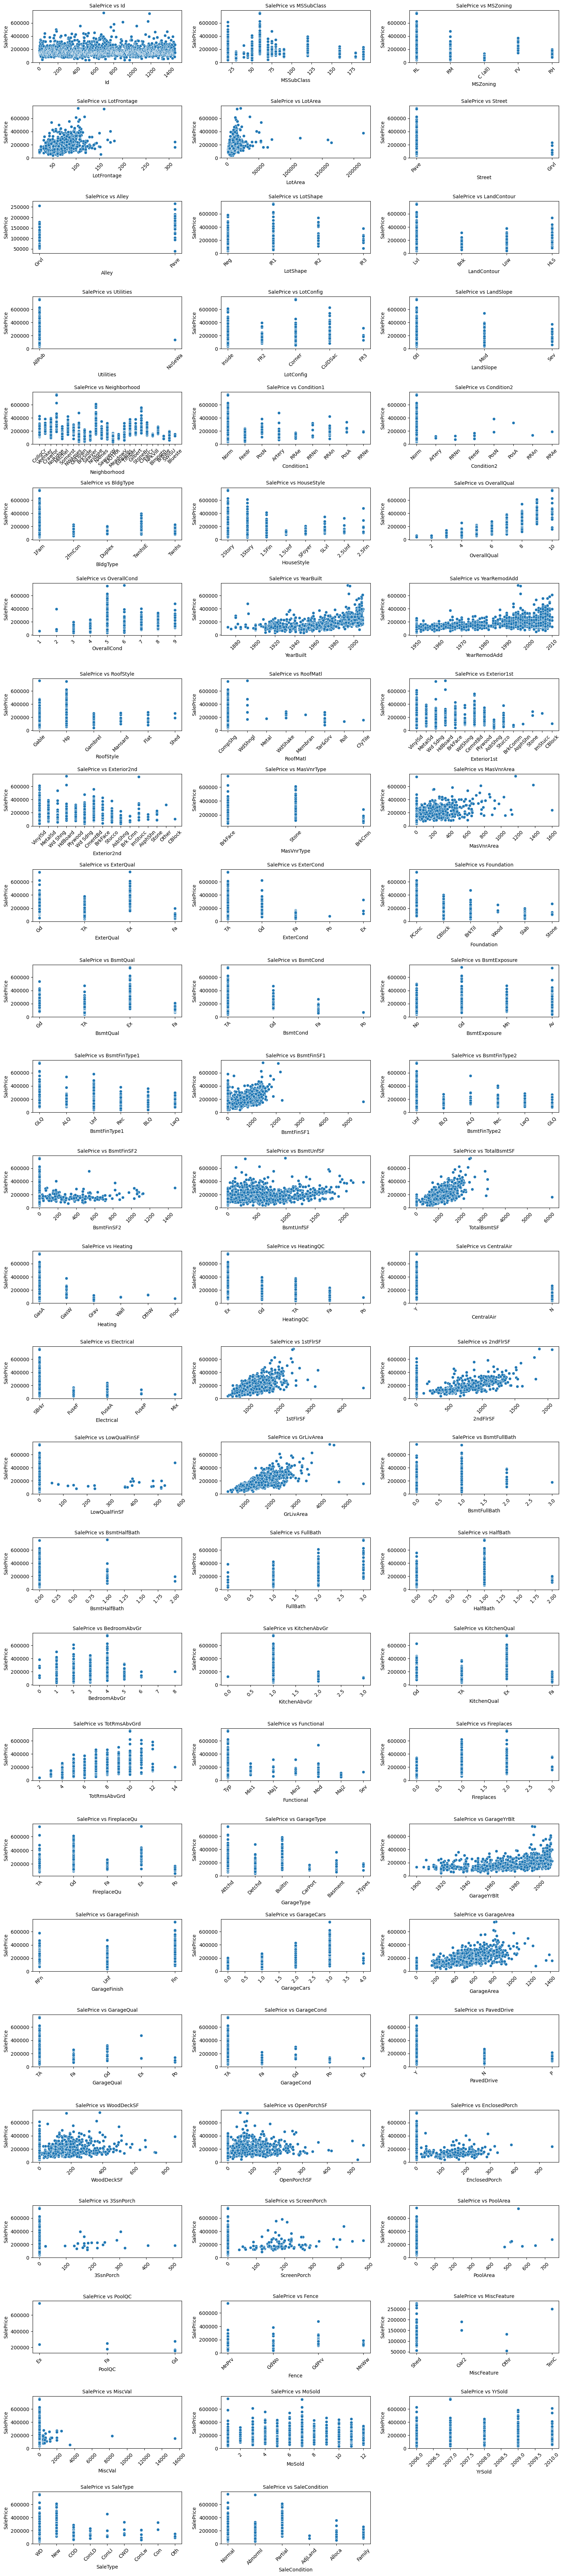

In [ ]:
columns_plot = [col for col in data.columns if col != 'SalePrice']

plt.figure(figsize=(16, 80))

for i, col in enumerate(columns_plot, start=1):
    plt.subplot(30, 3, i)
    sns.scatterplot(x=data[col], y=data['SalePrice'])
    plt.title(f'SalePrice vs {col}', fontsize=10)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Vamos a realizar pruebas de linealidad para explorar el conjunto de datos, y determinar si las relaciones entre las variables son lineales o no lineales

Primero veamos la correlación entre todas las características y el precio de la vivienda

In [ ]:
quant_data = data.select_dtypes(include=['int64', 'float64'])

correlation_pearson = quant_data.corr(method='pearson')

pearson_saleprice = correlation_pearson['SalePrice']

df_pearson = pd.DataFrame({'Variable': pearson_saleprice.index,
                           'Coeficiente Pearson': pearson_saleprice.values})

df_pearson = df_pearson[df_pearson['Variable'] != 'SalePrice']
df_pearson

Variable  Coeficiente Pearson
0              Id            -0.021917
1      MSSubClass            -0.084284
2     LotFrontage             0.351799
3         LotArea             0.263843
4     OverallQual             0.790982
5     OverallCond            -0.077856
6       YearBuilt             0.522897
7    YearRemodAdd             0.507101
8      MasVnrArea             0.477493
9      BsmtFinSF1             0.386420
10     BsmtFinSF2            -0.011378
11      BsmtUnfSF             0.214479
12    TotalBsmtSF             0.613581
13       1stFlrSF             0.605852
14       2ndFlrSF             0.319334
15   LowQualFinSF            -0.025606
16      GrLivArea             0.708624
17   BsmtFullBath             0.227122
18   BsmtHalfBath            -0.016844
19       FullBath             0.560664
20       HalfBath             0.284108
21   BedroomAbvGr             0.168213
22   KitchenAbvGr            -0.135907
23   TotRmsAbvGrd             0.533723
24     Fireplaces             0.466929
25    GarageYrBlt             0.486362
26     GarageCars             0.640409
27     GarageArea             0.623431
28     WoodDeckSF             0.324413
29    OpenPorchSF             0.315856
30  EnclosedPorch            -0.128578
31      3SsnPorch             0.044584
32    ScreenPorch             0.111447
33       PoolArea             0.092404
34        MiscVal            -0.021190
35         MoSold             0.046432
36         YrSold            -0.028923

Note que las correlaciones negativas no es tan tan cerca a -1 por lo tanto vamos a tomar las correlaciones positivas

In [ ]:
df_pearson_top = df_pearson.sort_values(by='Coeficiente Pearson')
print('Correlaciones positivas')
df_pearson_top.tail(8)

Correlaciones positivas


Variable  Coeficiente Pearson
23  TotRmsAbvGrd             0.533723
19      FullBath             0.560664
13      1stFlrSF             0.605852
12   TotalBsmtSF             0.613581
27    GarageArea             0.623431
26    GarageCars             0.640409
16     GrLivArea             0.708624
4    OverallQual             0.790982

Graficamos la regresion y también la regresión lineal de residuos, haciendo uso de las variables: 1stFlrSF,	TotalBsmtSF, GarageArea, GarageCars, GrLivArea y OverallQual

In [ ]:
def linear_regression_plot(X, y, columns):
    fig, axs = plt.subplots(len(columns), 2, figsize=(16, 6*len(columns)))

    for i, column in enumerate(columns):
        X_feature = X[[column]]

        X_train, X_val, y_train, y_val = train_test_split(X_feature, y, test_size=0.2, random_state=42)

        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)

        y_pred = linear_model.predict(X_val)

        X_LS = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)
        y_LS_pred = linear_model.predict(X_LS)

        residuals = y_val - y_pred

        axs[i, 0].scatter(X_feature, y, color='skyblue', label='Data')
        axs[i, 0].plot(X_LS, y_LS_pred, color='royalblue', label='Regression Line')
        axs[i, 0].set_xlabel(column)
        axs[i, 0].set_ylabel('Sale Price')
        axs[i, 0].legend()
        axs[i, 0].set_title(f'Regression Plot for {column}')

        axs[i, 1].scatter(y_pred, residuals, color='skyblue')
        axs[i, 1].axhline(y=0, color='royalblue', linestyle='--')
        axs[i, 1].set_xlabel('Predicted Values')
        axs[i, 1].set_ylabel('Residuals')
        axs[i, 1].set_title('Residual Plot')

    plt.tight_layout()
    return fig, axs

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

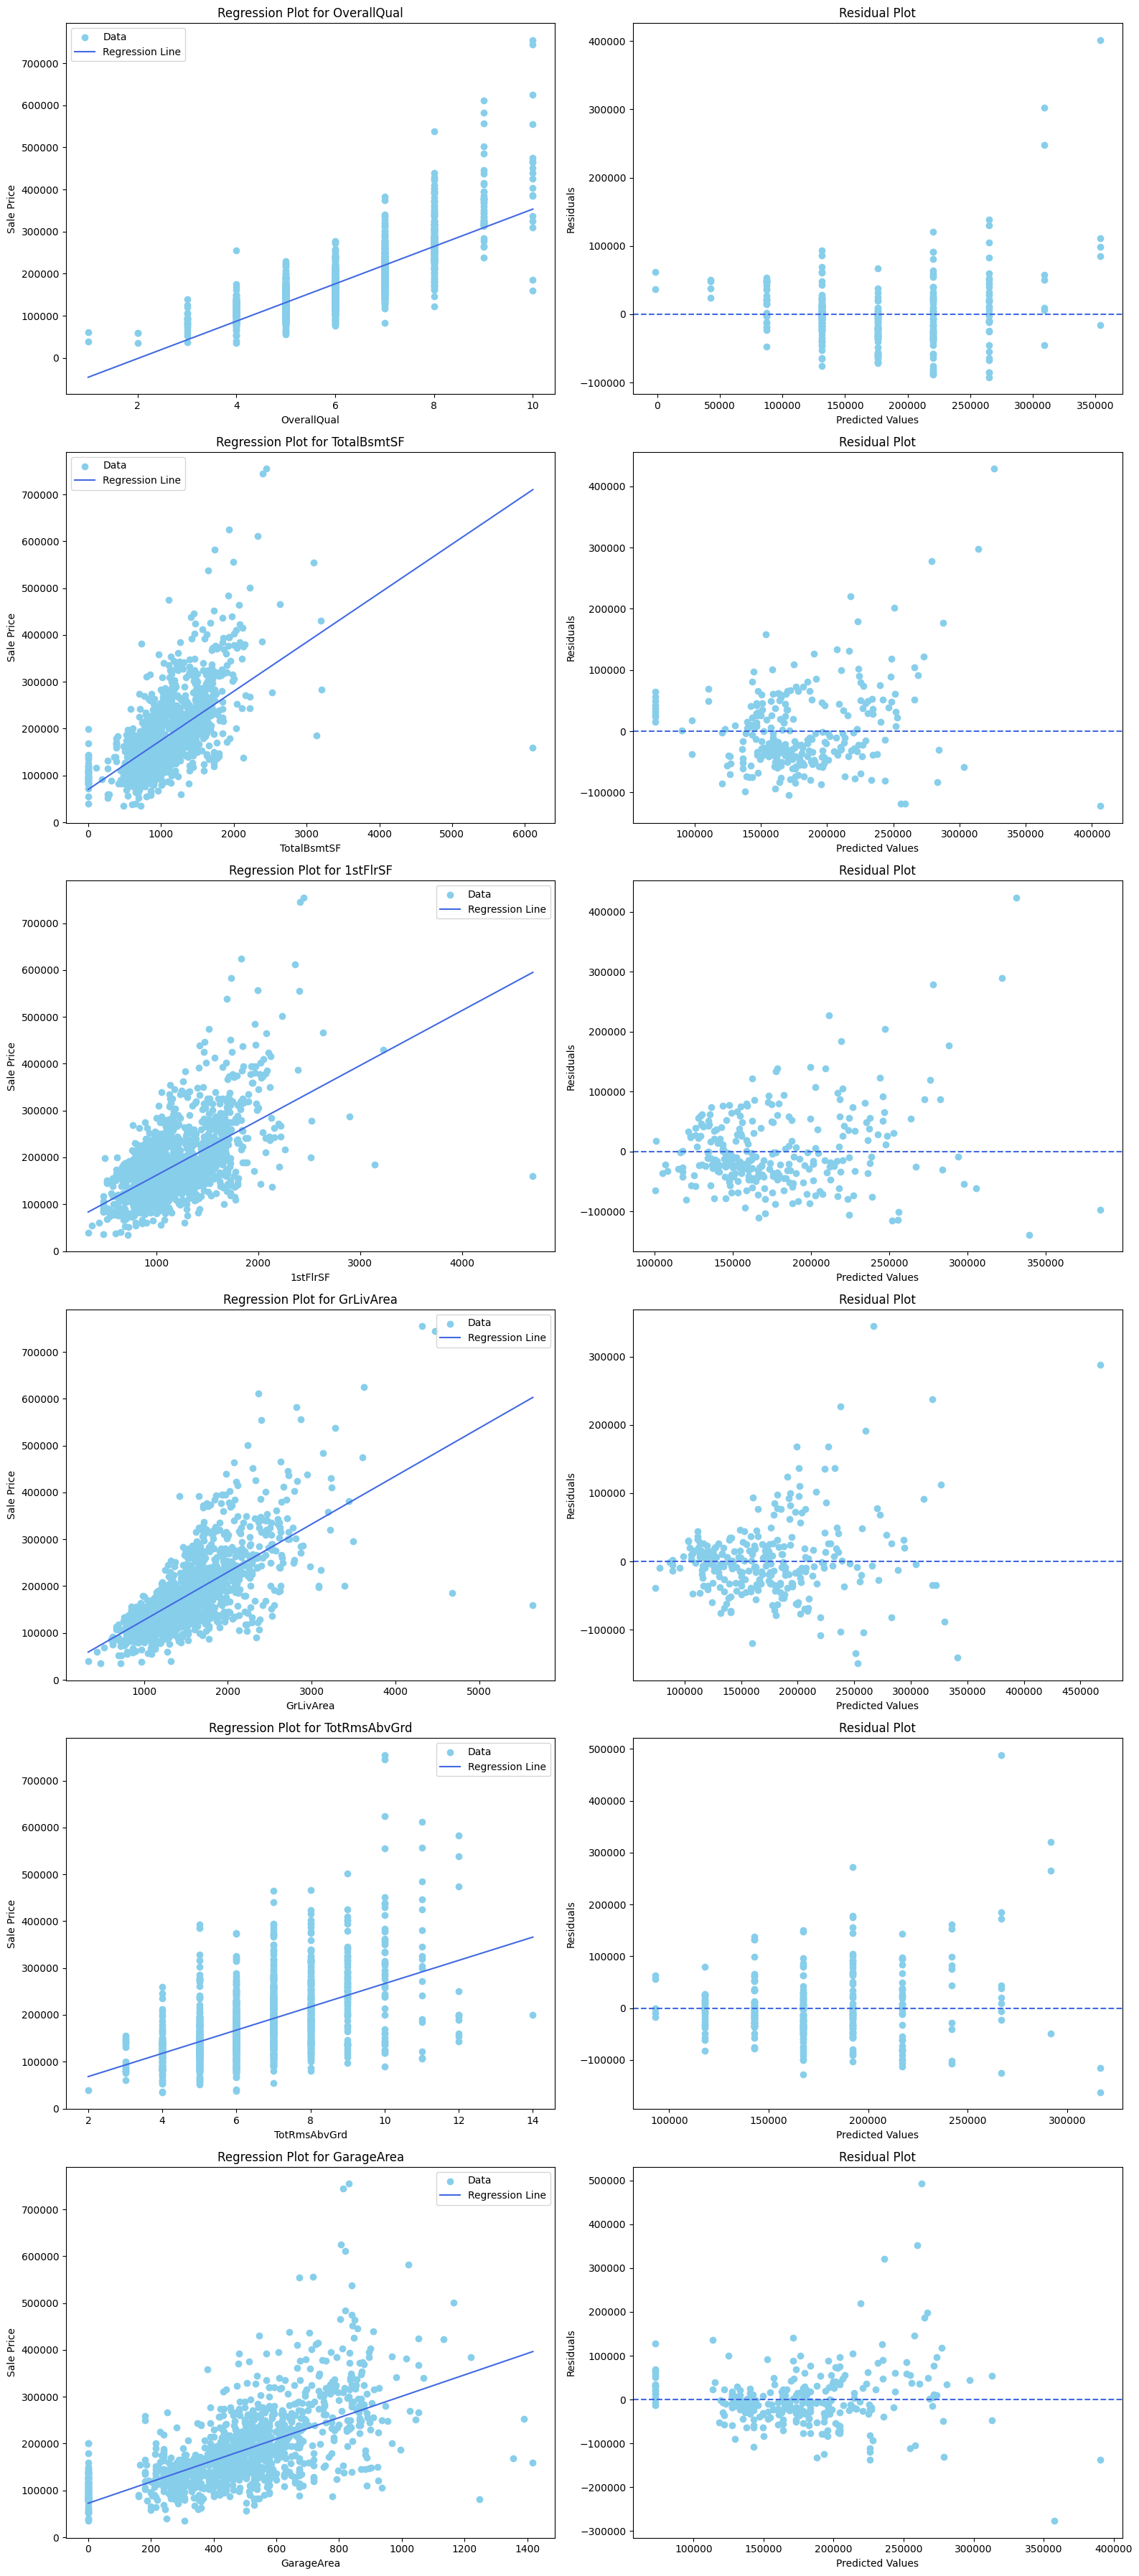

In [ ]:
columns = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

X_quant = data[columns]
y_quant = data['SalePrice']

ax = linear_regression_plot(X_quant, y_quant, columns)
plt.show()

Finalmente veamos la prueba estadística Q-Q

In [ ]:
def qq_plot(X, y, columns):
    fig, axs = plt.subplots(len(columns), figsize=(8, 6*len(columns)))

    for i, column in enumerate(columns):
        X_feature = X[[column]]

        X_train, X_val, y_train, y_val = train_test_split(X_feature, y, test_size=0.2, random_state=42)

        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)

        y_pred = linear_model.predict(X_val)

        residuals = y_val - y_pred

        stats.probplot(residuals, dist='norm', plot=axs[i])
        axs[i].set_title(f'Q-Q Plot of Residuals ({column})')
        axs[i].set_xlabel('Theoretical Quantiles')
        axs[i].set_ylabel('Residuals Quantiles')

    plt.tight_layout()
    return fig, axs

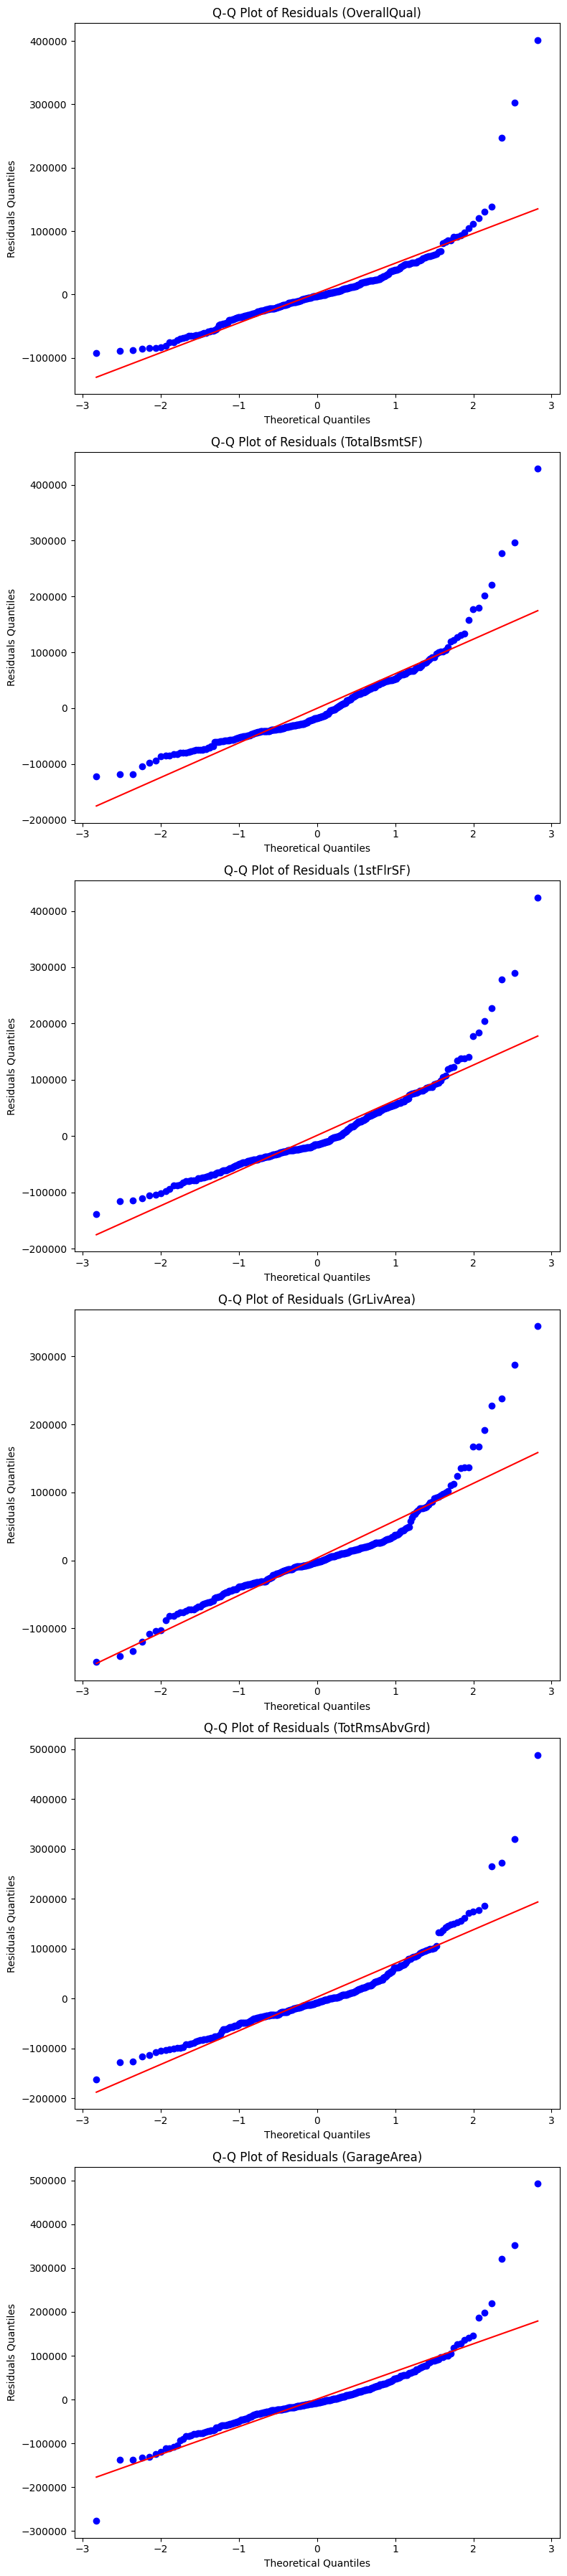

In [ ]:
fig, axs = qq_plot(X_quant, y_quant, columns)
plt.show()

Teniendo en cuenta las pruebas de las variables cuantitativas elegimos:
- OverallQual
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- TotRmsAbvGrd
- GarageArea

Ahora identifiquemos los datos faltantes

In [ ]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Teniendo en cuenta el análisis anterior y que hay variables con muchos datos faltantes y que no importan en el análisis, vamos a eliminarlas

In [ ]:
columns_to_drop = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'LotFrontage']

data_cleaned = data.drop(columns=columns_to_drop).copy()

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

Vamos a analizar si es necesario usar variables categóricas. Observemos la prueba ANOVA

In [ ]:
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
anova_results = []

for column in categorical_columns:
    groups = [data[data[column] == category]['SalePrice'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)

    anova_results.append((column, f_statistic, p_value))

anova_df = pd.DataFrame(anova_results, columns=['Variable', 'F-statistic', 'p-value'])

significant_anova = anova_df[(anova_df['p-value'] < 0.05) & (anova_df['F-statistic'] > 40)]

print("\nVariables con p-values significativos (p < 0.05):")
print(significant_anova)


Variables con p-values significativos (p < 0.05):
         Variable  F-statistic        p-value
0        MSZoning    43.840282   8.817634e-35
2        LotShape    40.132852   6.447524e-25
7    Neighborhood    71.784865  1.558600e-225
17      ExterQual   443.334831  1.439551e-204
19     Foundation   100.253851   5.791895e-91
26      HeatingQC    88.394462   2.667062e-67
27     CentralAir    98.305344   1.809506e-22
29    KitchenQual   407.806352  3.032213e-192
35     PavedDrive    42.024179   1.803569e-18
37  SaleCondition    45.578428   7.988268e-44


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Para este caso tomaremos las variables categóricas con los p-values más pequeños

In [ ]:
def categorical_analysis(data, column):
    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data_cleaned, x=column, palette='viridis')
    plt.title(f'Distribución de {column}')
    plt.xticks(rotation=45)
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_cleaned, x=column, y='SalePrice', palette='viridis')
    plt.title(f'Boxplot de {column} vs SalePrice')
    plt.xticks(rotation=45)
    plt.show()

    # Tabla de frecuencias
    freq_table = data_cleaned[column].value_counts().reset_index()
    freq_table.columns = [column, 'Frequency']
    freq_table['Percentage'] = (freq_table['Frequency'] / len(data)) * 100
    print(f'Tabla de frecuencias de {column}:')
    print(freq_table)
    print('\n')

<ipython-input-8-e61d4107e162>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x=column, palette='viridis')


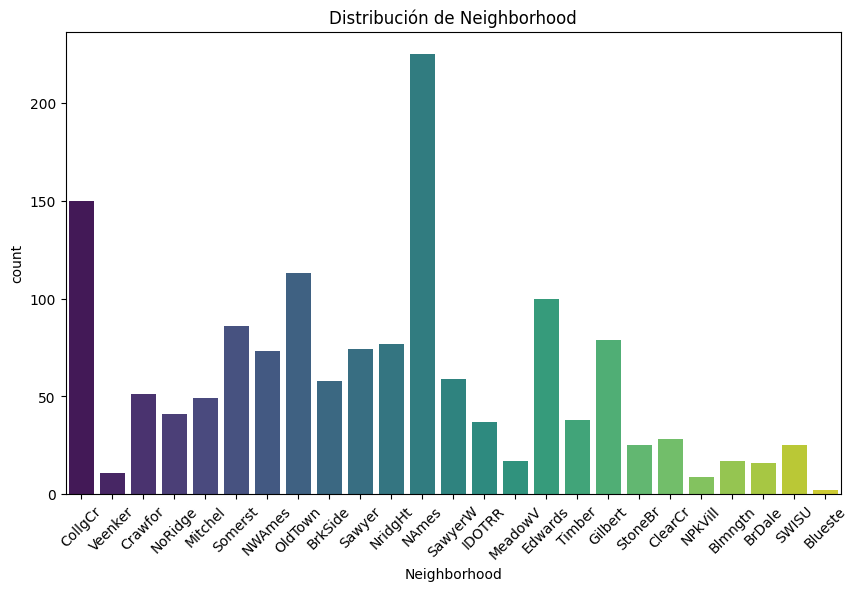

<ipython-input-8-e61d4107e162>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cleaned, x=column, y='SalePrice', palette='viridis')


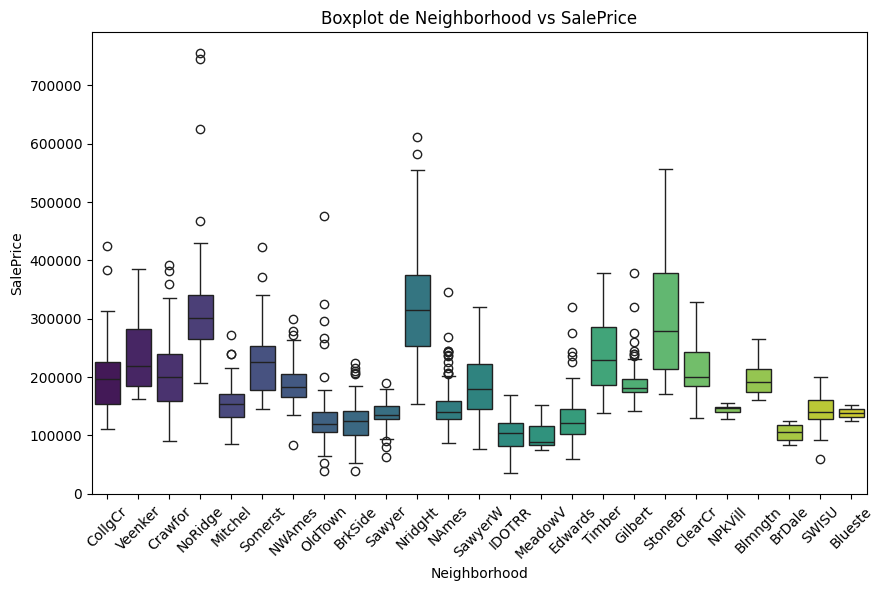

Tabla de frecuencias de Neighborhood:
   Neighborhood  Frequency  Percentage
0         NAmes        225   15.410959
1       CollgCr        150   10.273973
2       OldTown        113    7.739726
3       Edwards        100    6.849315
4       Somerst         86    5.890411
5       Gilbert         79    5.410959
6       NridgHt         77    5.273973
7        Sawyer         74    5.068493
8        NWAmes         73    5.000000
9       SawyerW         59    4.041096
10      BrkSide         58    3.972603
11      Crawfor         51    3.493151
12      Mitchel         49    3.356164
13      NoRidge         41    2.808219
14       Timber         38    2.602740
15       IDOTRR         37    2.534247
16      ClearCr         28    1.917808
17      StoneBr         25    1.712329
18        SWISU         25    1.712329
19      MeadowV         17    1.164384
20      Blmngtn         17    1.164384
21       BrDale         16    1.095890
22      Veenker         11    0.753425
23      NPkVill          9

<ipython-input-8-e61d4107e162>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x=column, palette='viridis')


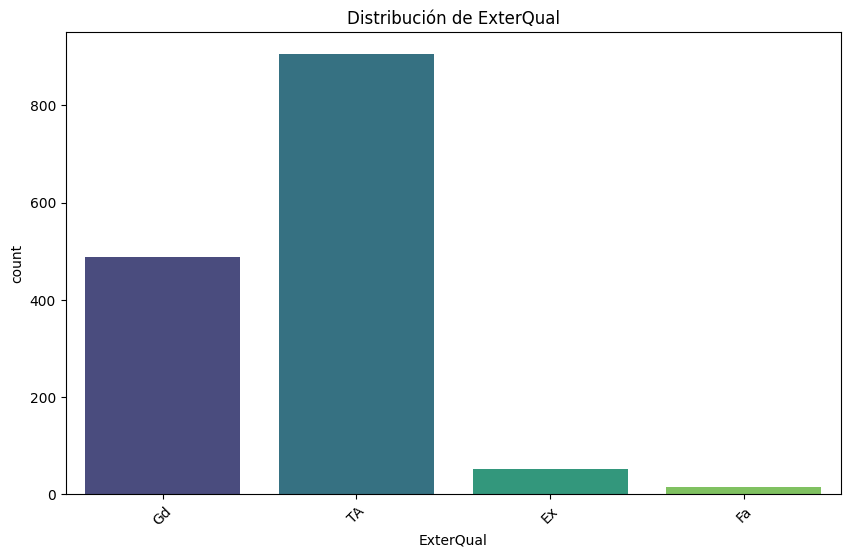

<ipython-input-8-e61d4107e162>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cleaned, x=column, y='SalePrice', palette='viridis')


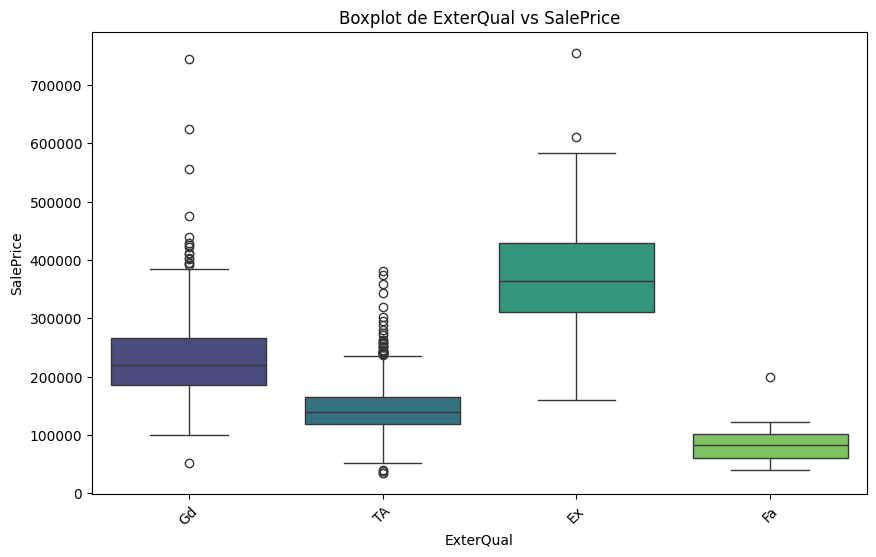

Tabla de frecuencias de ExterQual:
  ExterQual  Frequency  Percentage
0        TA        906   62.054795
1        Gd        488   33.424658
2        Ex         52    3.561644
3        Fa         14    0.958904




In [ ]:
categorical_column = 'Neighborhood'
categorical_analysis(data_cleaned, categorical_column)

categorical_column2 = 'ExterQual'
categorical_analysis(data_cleaned, categorical_column2)

Luego de realizar las pruebas ANOVA y el Análisis Descriptivo escogimos las siguientes variables categóricas:
- Neighborhood   
- ExterQual

Ahora vamos a evaluar la normalización de características según el método a utilizar

In [ ]:
categorical_features = ['Neighborhood', 'ExterQual']
numeric_features = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    data_cleaned[feature] = label_encoders[feature].fit_transform(data_cleaned[feature])

# Calcular las frecuencias de cada categoría en las variables categóricas
category_frequencies = {}
for feature in categorical_features:
    category_frequencies[feature] = data_cleaned[feature].value_counts(normalize=True)

# Reemplazar cada valor en las variables categóricas con su frecuencia ponderada
for feature in categorical_features:
    data_cleaned[feature] = data_cleaned[feature].map(category_frequencies[feature])

X = data_cleaned[numeric_features + categorical_features]
y = data_cleaned['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, val_index in k_fold.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

mean_score = np.mean(scores)
print("Puntaje de rendimiento promedio:", mean_score)

Puntaje de rendimiento promedio: 39028.42660443204


### 2. Modelado con spline

#### Splines cúbicos naturales

Funciones para el modelado y gráficas de splines cúbicos naturales

In [ ]:
def natural_cubic_spline(X_train, X_val, y_train, y_val, df_values):
    results = []

    for df in df_values:
        all_rmse = []
        all_mae = []
        all_r2 = []

        for column in X_train.columns:
            X_train_col = X_train[column].values.reshape(-1, 1)
            X_val_col = X_val[column].values.reshape(-1, 1)

            X_spline_train_natural = dmatrix(f"cr(X, df={df})", {"X": X_train_col}, return_type='dataframe')
            X_spline_val_natural = dmatrix(f"cr(X, df={df})", {"X": X_val_col}, return_type='dataframe')

            model_spline_natural = LinearRegression()
            model_spline_natural.fit(X_spline_train_natural, y_train)

            y_spline_val_pred_natural = model_spline_natural.predict(X_spline_val_natural)

            rmse_val_natural = np.sqrt(mean_squared_error(y_val, y_spline_val_pred_natural))
            mae_val_natural = mean_absolute_error(y_val, y_spline_val_pred_natural)
            r2_val_natural = r2_score(y_val, y_spline_val_pred_natural)

            all_rmse.append(rmse_val_natural)
            all_mae.append(mae_val_natural)
            all_r2.append(r2_val_natural)

        avg_rmse = np.mean(all_rmse)
        avg_mae = np.mean(all_mae)
        avg_r2 = np.mean(all_r2)

        results.append({
            "Grados de libertad": df,
            "RMSE": avg_rmse,
            "MAE": avg_mae,
            "R2": avg_r2
        })

    return pd.DataFrame(results)

def nc_spline_plot(X_train, X_val, y_train, y_val, df_values, variable):
    X_LS = np.linspace(X_train.min(), X_train.max(), 100)

    plt.figure(figsize=(14, 8))
    plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5)
    plt.scatter(X_train, y_train, s=10, color='gray', alpha=0.8)

    for df in df_values:
        X_spline_train_natural = dmatrix(f"cr(X, df={df})", {"X": X_train}, return_type='dataframe')

        model_spline_natural = LinearRegression()
        model_spline_natural.fit(X_spline_train_natural, y_train)

        X_spline_plot_natural = dmatrix(f"cr(X, df={df})", {"X": X_LS}, return_type='dataframe')
        y_spline_plot_natural = model_spline_natural.predict(X_spline_plot_natural)

        plt.plot(X_LS, y_spline_plot_natural, label=f"Spline cúbico natural con {df} grados de libertad")

    plt.xlabel(variable)
    plt.ylabel("Price")
    plt.title(f"Spline Cúbico Natural para la Variable '{variable}'")
    plt.legend()
    plt.show()

Resultados modelado con splines de las variables numéricas y categóricas elegidas

In [ ]:
X = data_cleaned[numeric_features + categorical_features]
y = data_cleaned['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_values = [3, 5, 7]

results_df = natural_cubic_spline(X_train, X_val, y_train, y_val, df_values)
results_df

Grados de libertad          RMSE           MAE        R2
0                   3  66840.306658  46732.974743  0.405531
1                   5  65409.737617  44841.098422  0.429780
2                   7  65312.602108  44625.149722  0.432480

Gráfica de splines para la variable 'OverallQual':


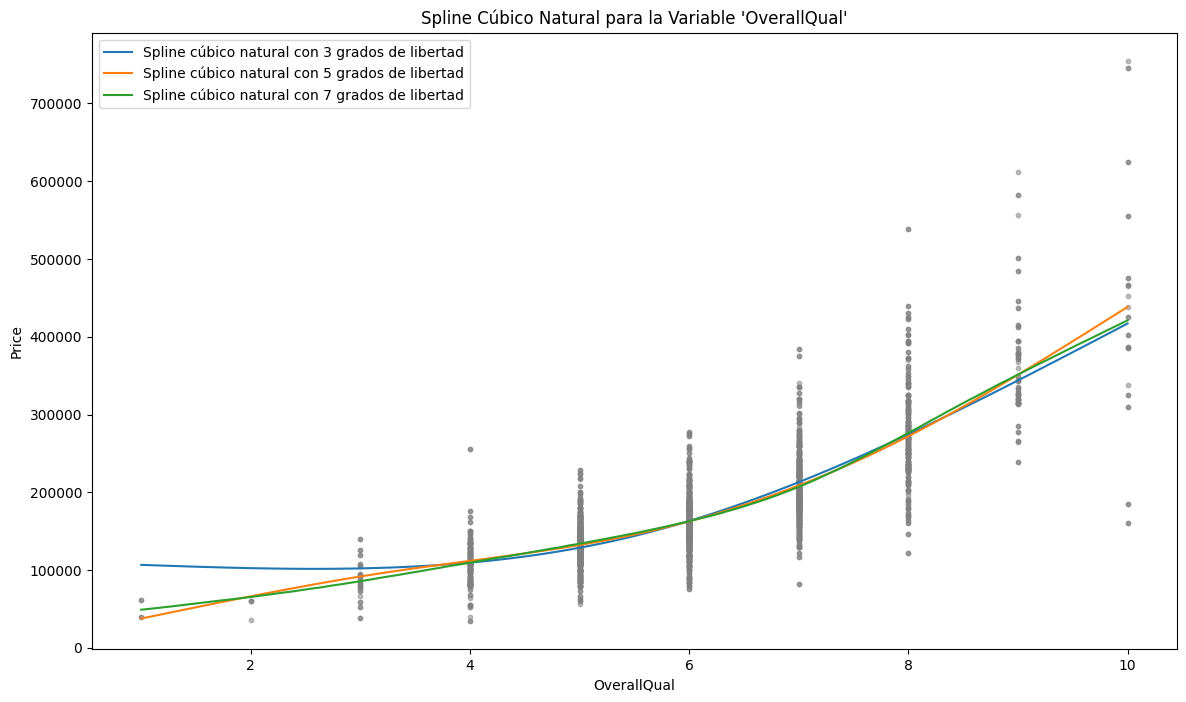

Gráfica de splines para la variable 'TotalBsmtSF':


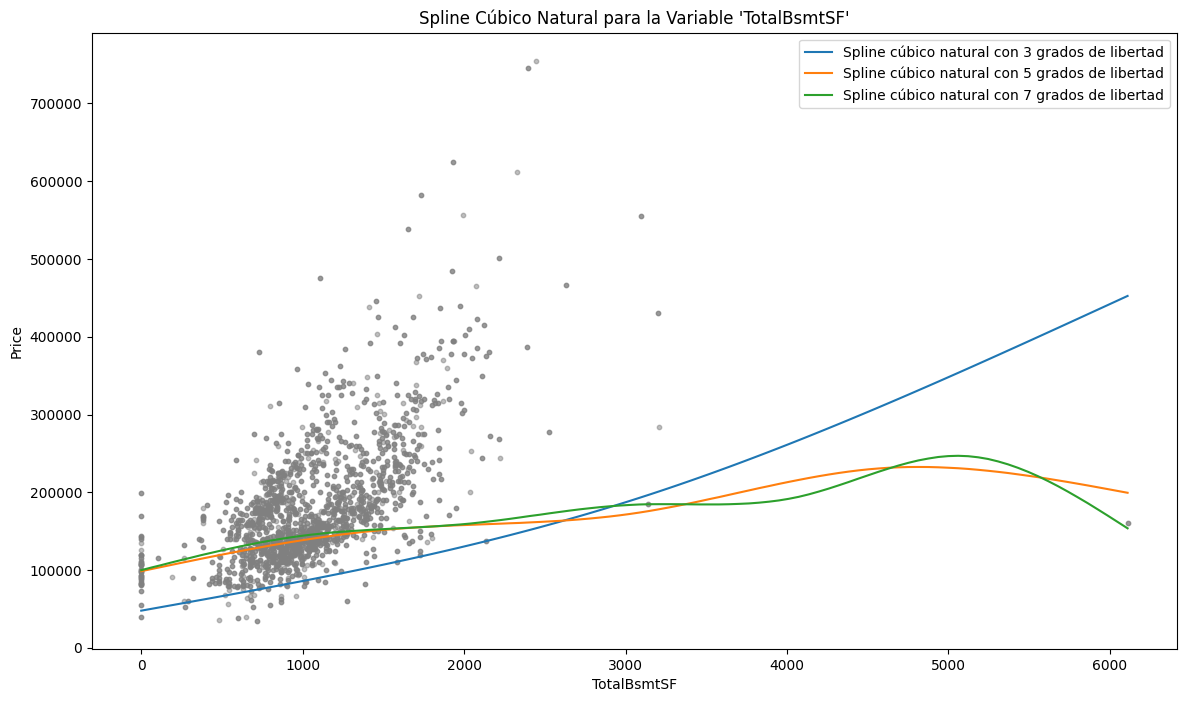

Gráfica de splines para la variable '1stFlrSF':


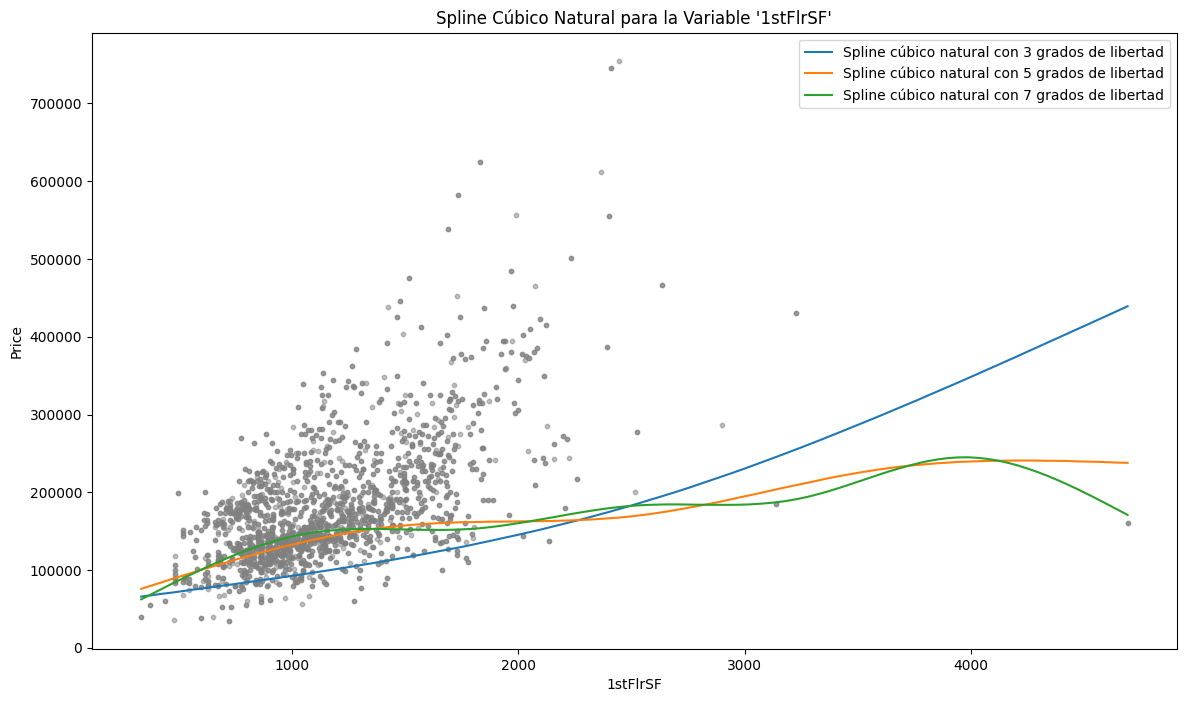

Gráfica de splines para la variable 'GrLivArea':


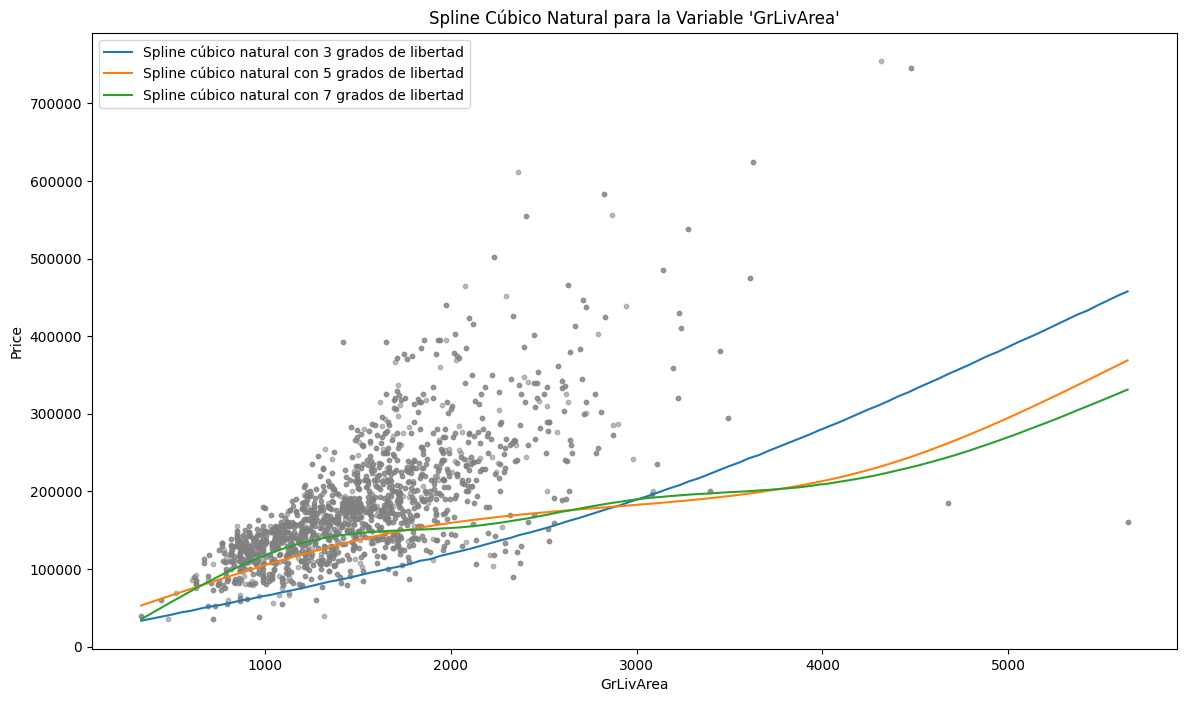

Gráfica de splines para la variable 'TotRmsAbvGrd':


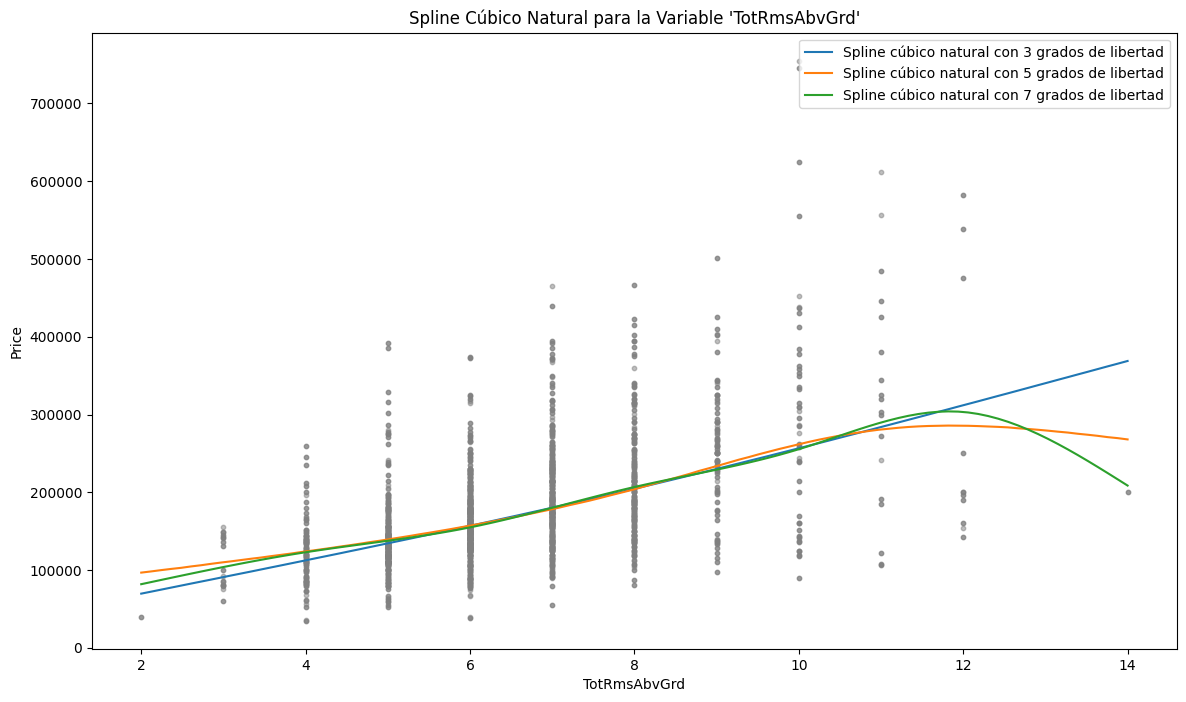

Gráfica de splines para la variable 'GarageArea':


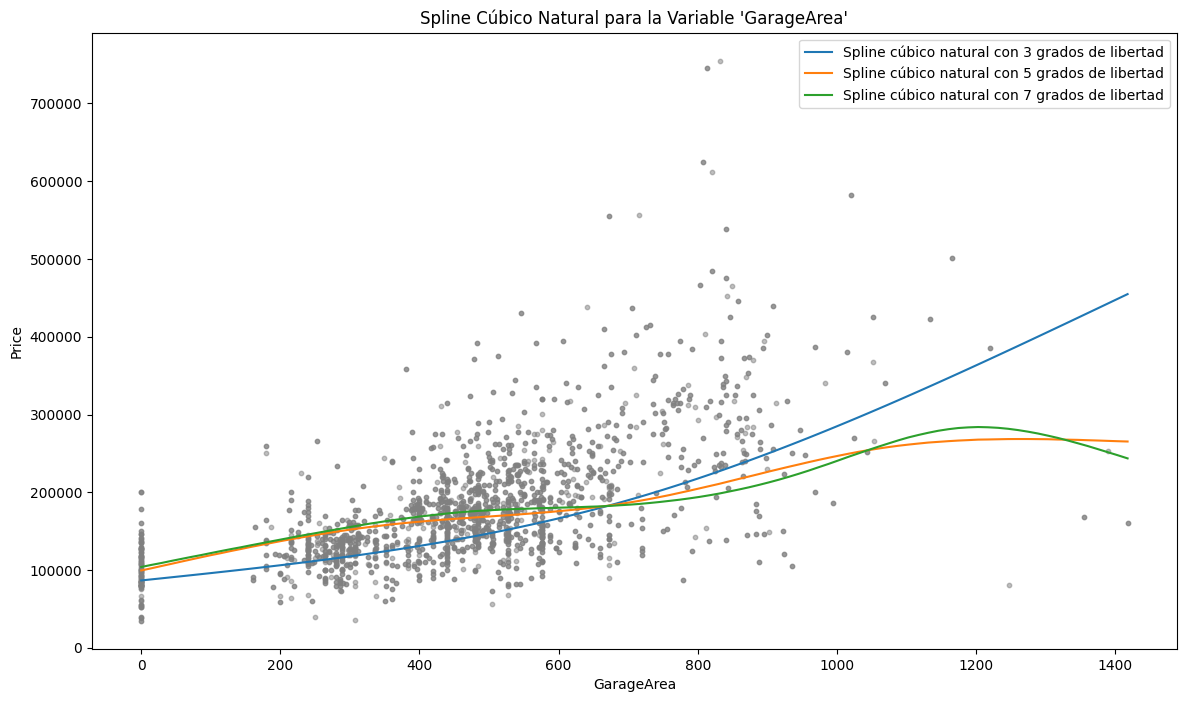

Gráfica de splines para la variable 'Neighborhood':


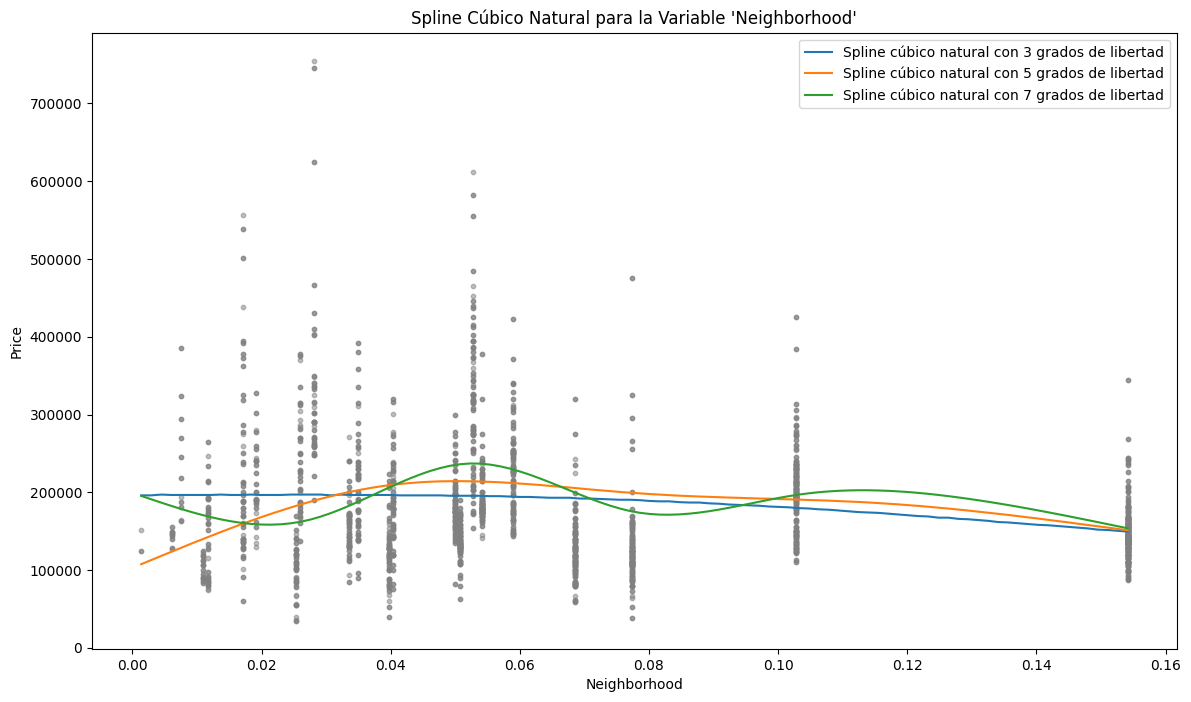

Gráfica de splines para la variable 'ExterQual':


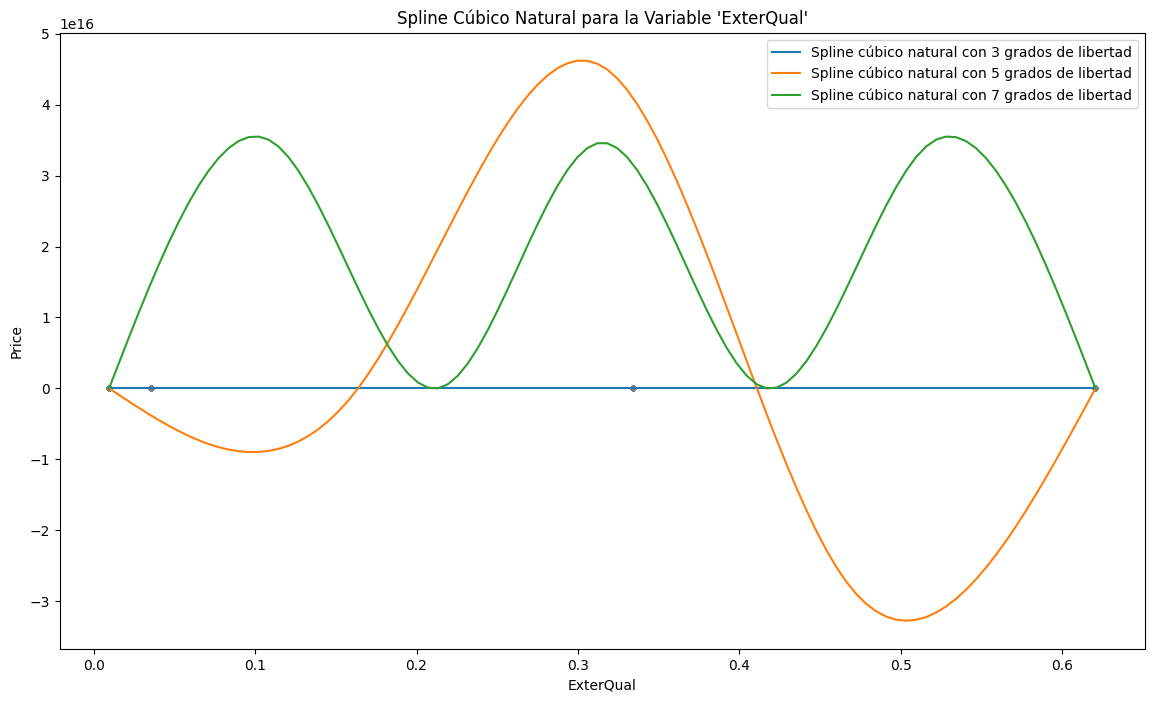

In [ ]:
for variable in X.columns:
    print(f"Gráfica de splines para la variable '{variable}':")
    nc_spline_plot(X_train[variable], X_val[variable], y_train, y_val, df_values, variable)

Note que para las variables categóricas no era necesario realizar splines, esto se puede notar en las gráficas, por lo tanto solo realizaremos splines cúbicos naturales a las variables numéricas elegidas

In [ ]:
X_numeric = data_cleaned[numeric_features]
y_numeric = data_cleaned['SalePrice']

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_numeric, y_numeric, test_size=0.2, random_state=42)

results_cc_num = natural_cubic_spline(X_train2, X_val2, y_train2, y_val2, df_values)
results_cc_num

Grados de libertad          RMSE           MAE        R2
0                   3  63759.002756  45168.231164  0.462940
1                   5  63321.150917  43176.712280  0.470476
2                   7  63347.407937  42906.103739  0.470564

Con solo usar variables numéricas el modelo obtuvo un mejor resultado teniendo en cuenta las métricas

Gráfica de splines para la variable 'OverallQual':


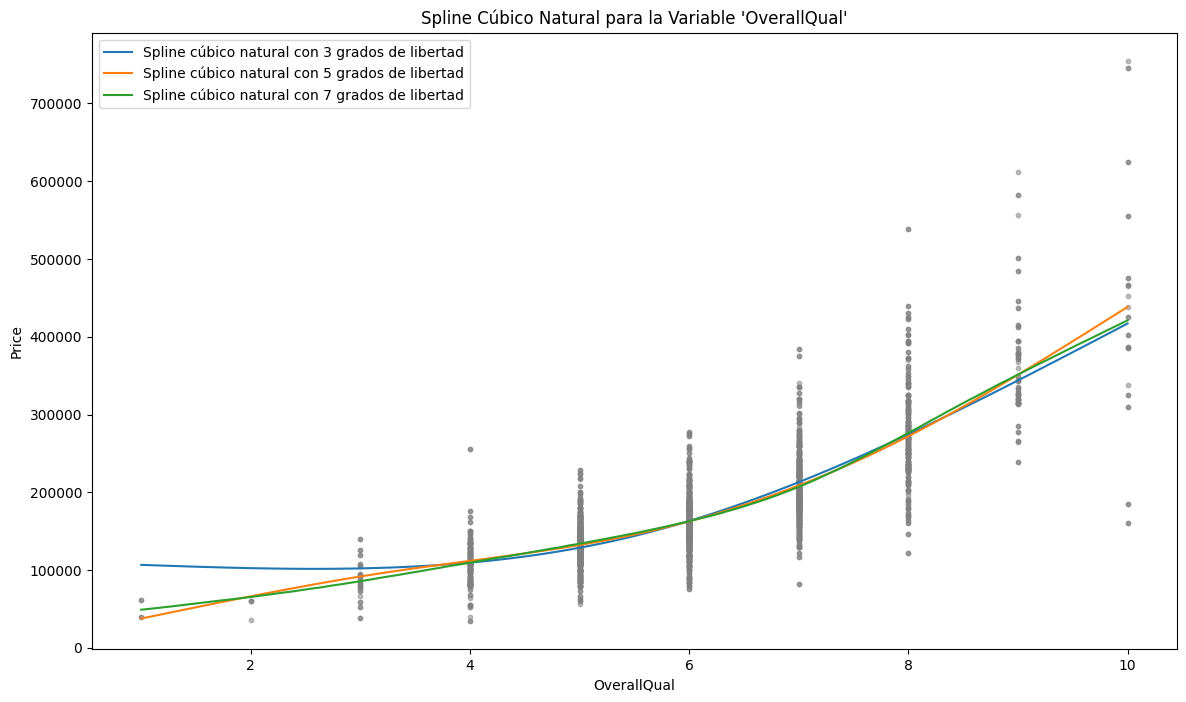

Gráfica de splines para la variable 'TotalBsmtSF':


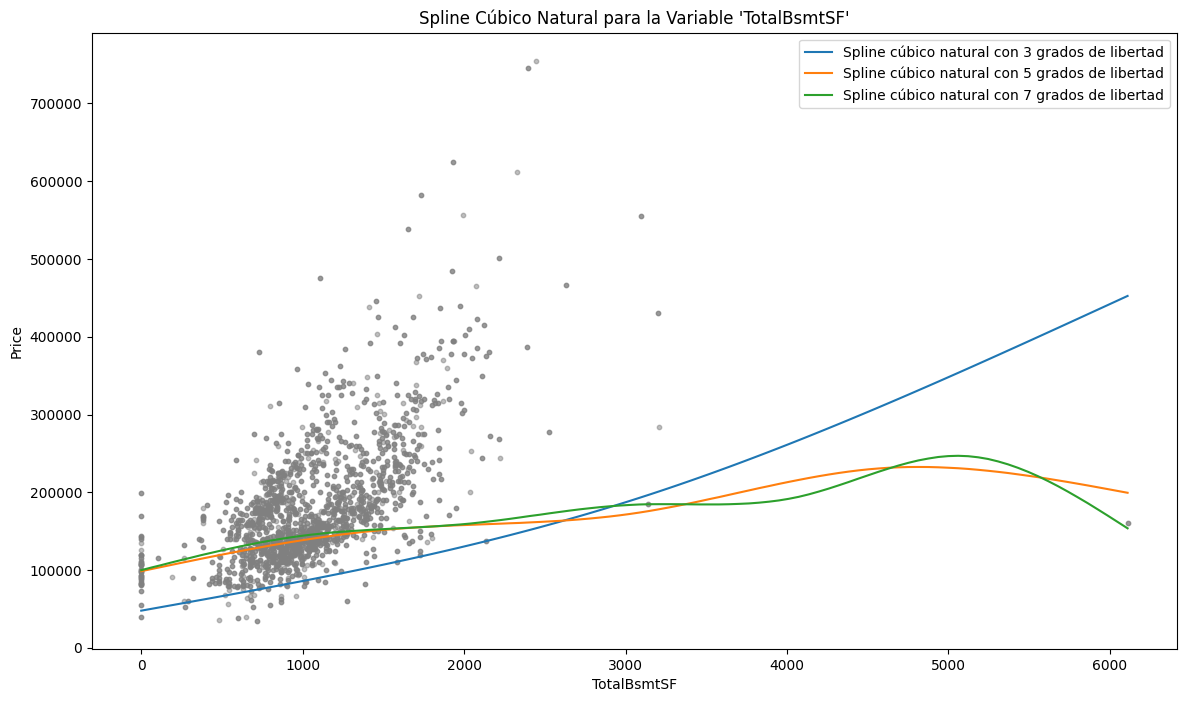

Gráfica de splines para la variable '1stFlrSF':


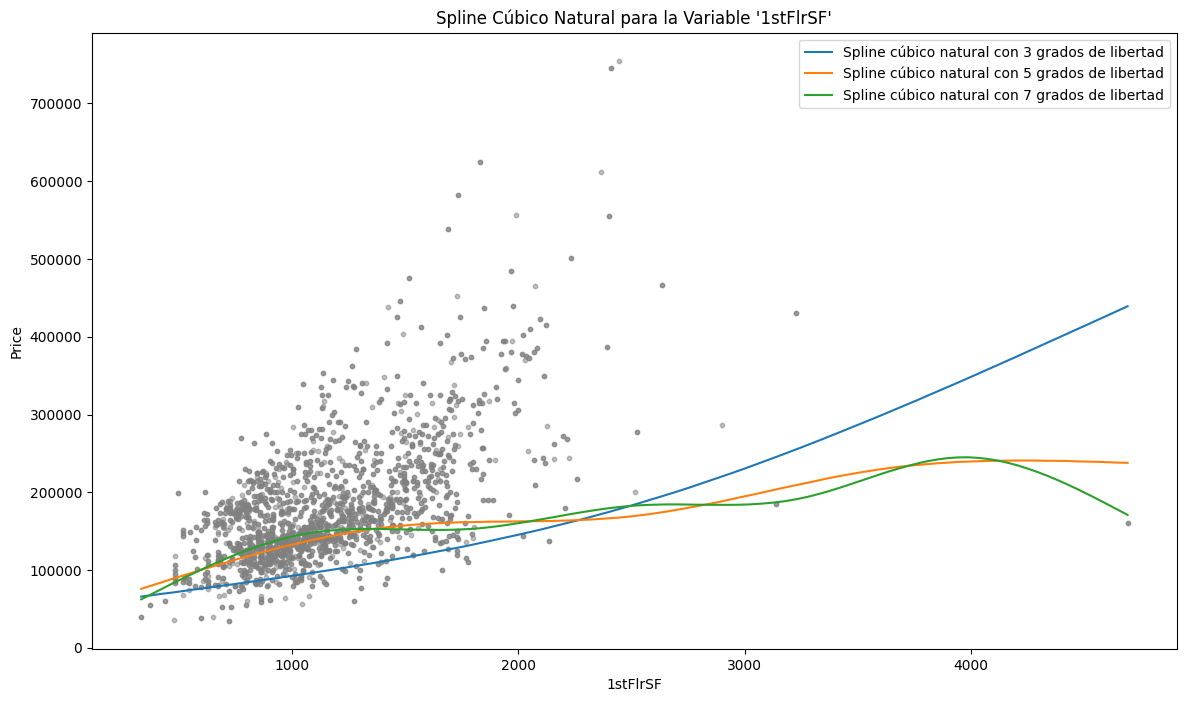

Gráfica de splines para la variable 'GrLivArea':


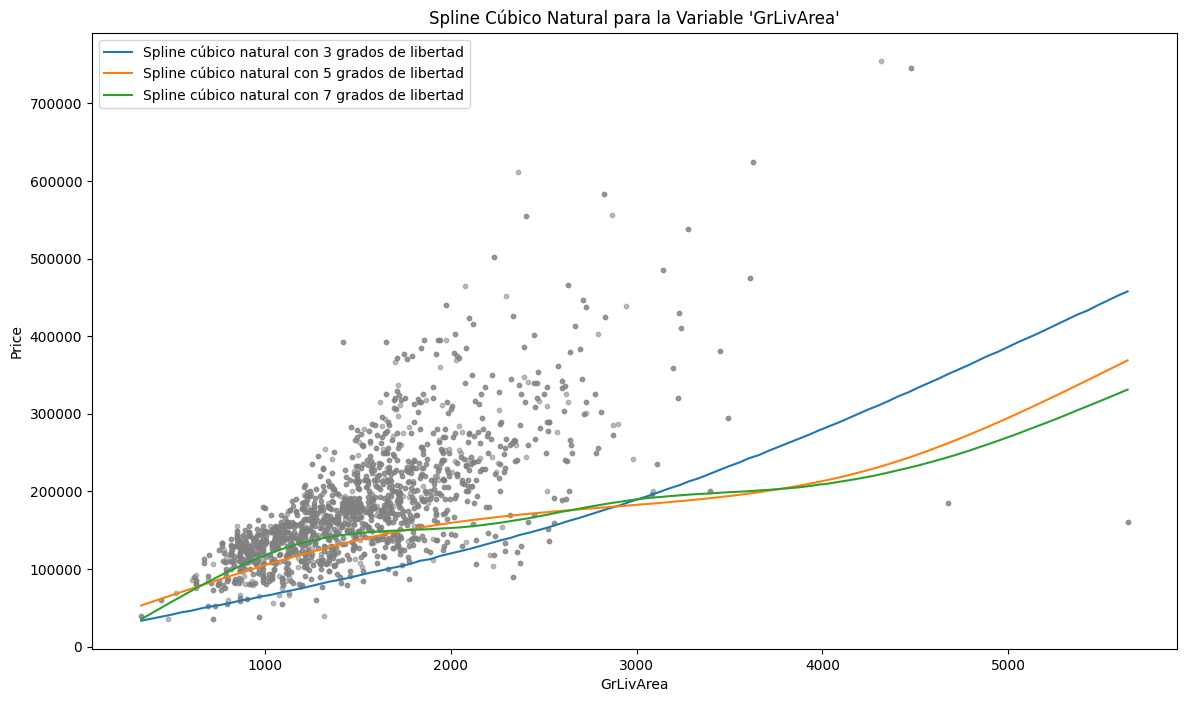

Gráfica de splines para la variable 'TotRmsAbvGrd':


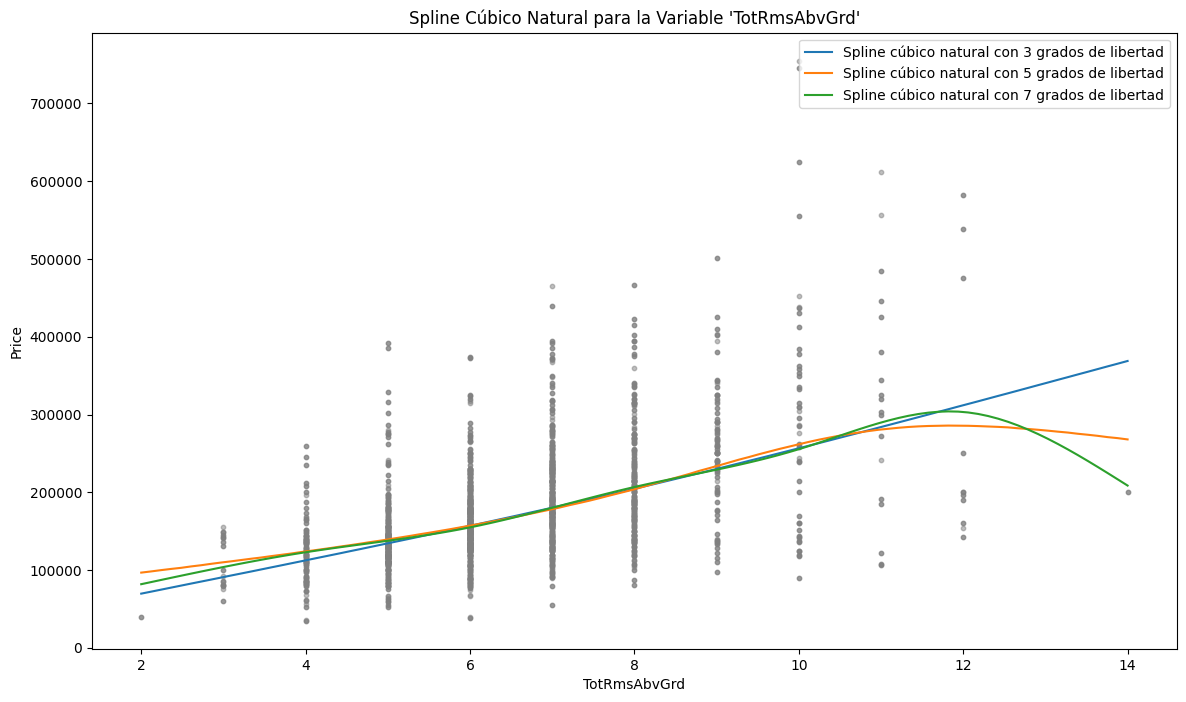

Gráfica de splines para la variable 'GarageArea':


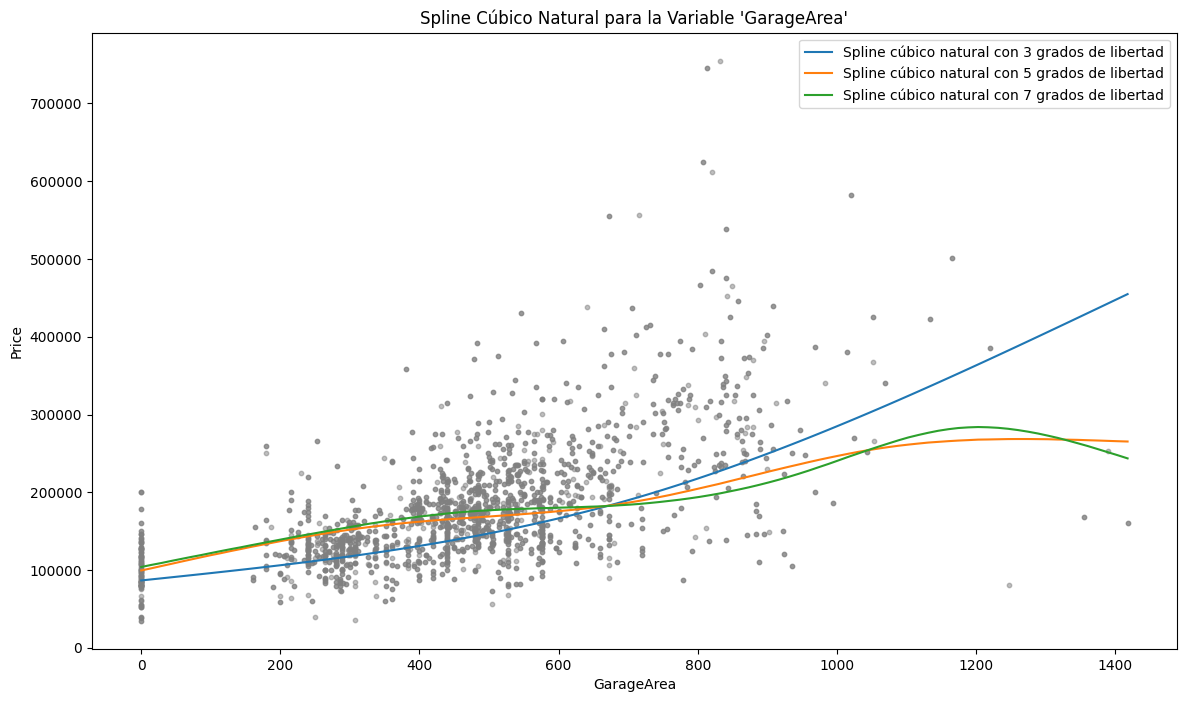

In [ ]:
for variable in X_numeric.columns:
    print(f"Gráfica de splines para la variable '{variable}':")
    natural_spline_results = nc_spline_plot(X_train2[variable], X_val2[variable], y_train2, y_val2, df_values, variable)

#### Splines naturales

Funciones para el modelado y gráficas de splines naturales

In [ ]:
def natural_bspline(X_train, X_val, y_train, y_val, knots_list):
    results = []
    all_rmse = []
    all_mae = []
    all_r2 = []

    for i, knots in enumerate(knots_list):
        num_nodes = len(knots) + 2

        X_train_col = X_train.iloc[:, i]
        X_val_col = X_val.iloc[:, i]

        X_spline_train = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                                 {"data": X_train_col}, return_type='dataframe')
        X_spline_val = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                               {"data": X_val_col}, return_type='dataframe')

        model_spline = LinearRegression()
        model_spline.fit(X_spline_train, y_train)

        y_spline_val_pred = model_spline.predict(X_spline_val)

        rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))
        mae_val = mean_absolute_error(y_val, y_spline_val_pred)
        r2_val = r2_score(y_val, y_spline_val_pred)

        all_rmse.append(rmse_val)
        all_mae.append(mae_val)
        all_r2.append(r2_val)

    average_rmse = np.mean(all_rmse)
    average_mae = np.mean(all_mae)
    average_r2 = np.mean(all_r2)

    results.append({
        "Nodes": num_nodes,
        "RMSE": average_rmse,
        "MAE": average_mae,
        "R2": average_r2
    })

    return pd.DataFrame(results)

def bspline_plot(X_train, X_val, y_train, y_val, knots_list, variable):
    X_LS = np.linspace(X_train.min(), X_train.max(), 100)

    plt.figure(figsize=(14, 8))
    plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5)
    plt.scatter(X_train, y_train, s=10, color='gray', alpha=0.8)

    for knots in knots_list:
        num_nodes = len(knots) + 2

        X_spline_train = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                                 {"data": X_train}, return_type='dataframe')

        model_spline = LinearRegression()
        model_spline.fit(X_spline_train, y_train)

        X_spline_plot = dmatrix(f"bs(data, knots={knots}, degree=3, include_intercept=False)",
                                {"data": X_LS}, return_type='dataframe')
        y_spline_plot = model_spline.predict(X_spline_plot)

        plt.plot(X_LS, y_spline_plot, label=f"Spline B-spline con {num_nodes} nodos")

    plt.xlabel(variable)
    plt.ylabel("Price")
    plt.title("Estimación B-spline con Diferentes Nodos")
    plt.legend()
    plt.show()


In [ ]:
knots_list = [
    (2, 6, 8),           # Knots para OverallQual
    (1000, 2000, 2500),  # Knots para TotalBsmtSF
    (1000, 2000, 2500),  # Knots para 1stFlrSF
    (1000, 2000, 2500),  # Knots para GrLivArea
    (4, 6, 8),           # Knots para TotRmsAbvGrd
    (300, 600, 900)      # Knots para GarageArea
]

results_bspline_num = natural_bspline(X_train2, X_val2, y_train2, y_val2, knots_list)
results_bspline_num

Nodes          RMSE           MAE        R2
0      5  62533.849824  41716.924598  0.482267

Gráfica de B-splines para la variable 'OverallQual':


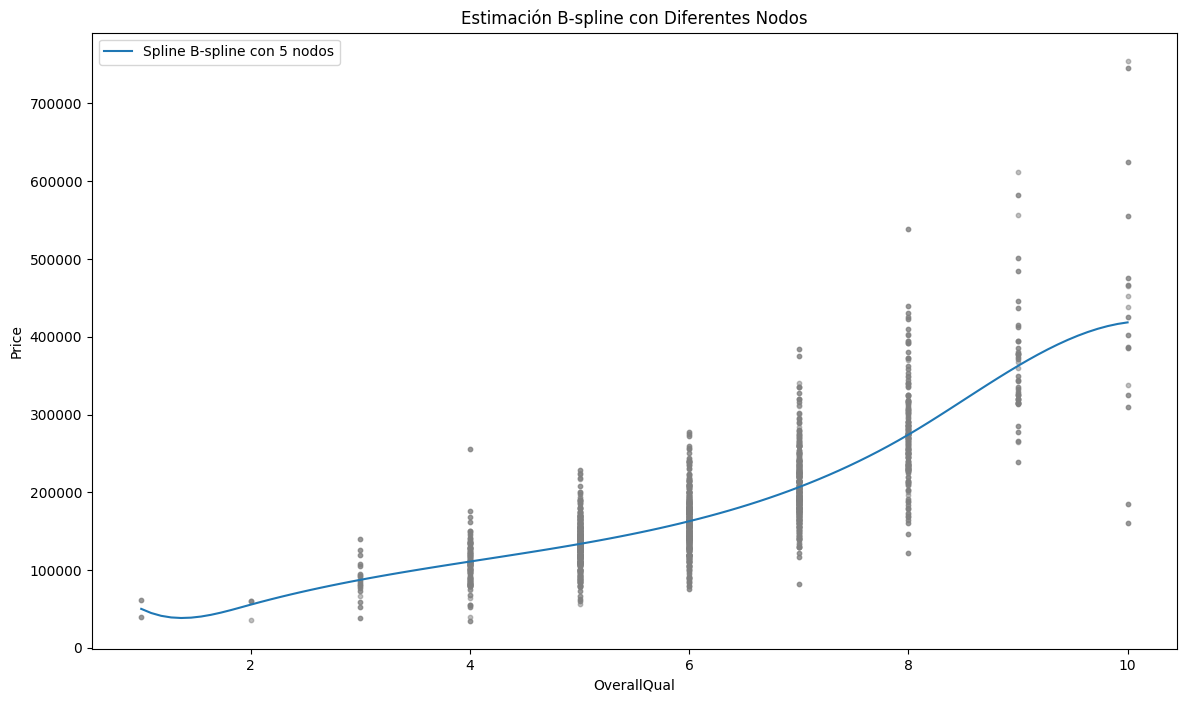

Gráfica de B-splines para la variable 'TotalBsmtSF':


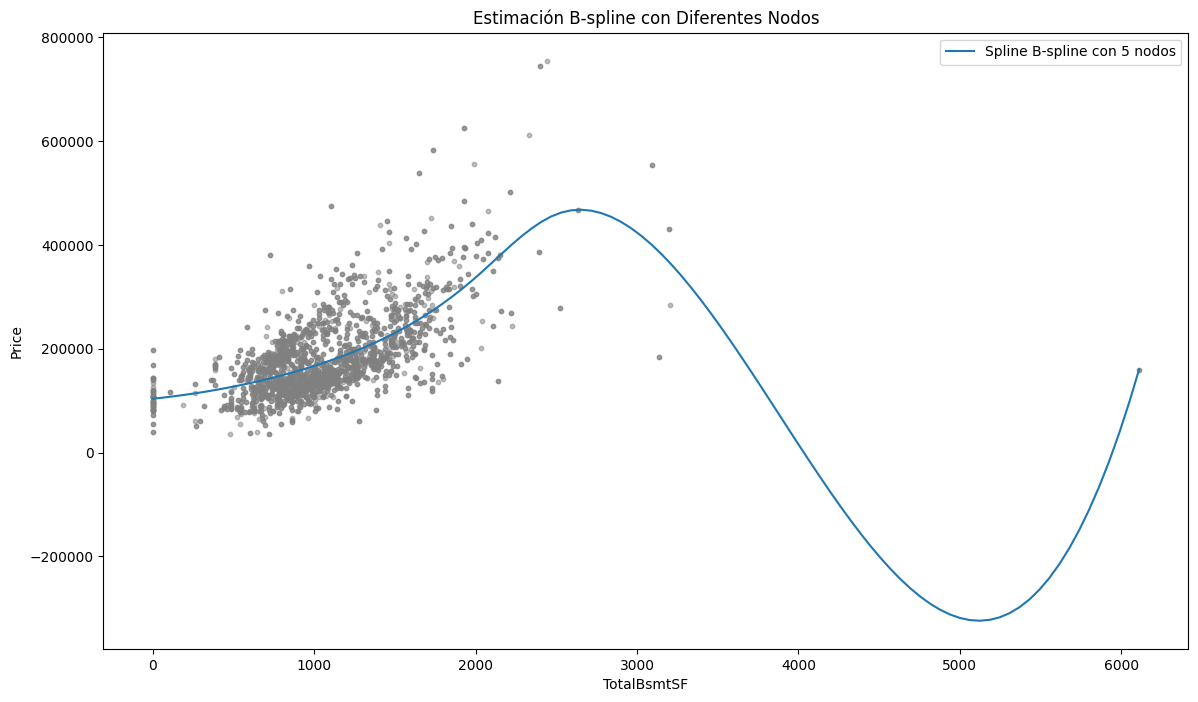

Gráfica de B-splines para la variable '1stFlrSF':


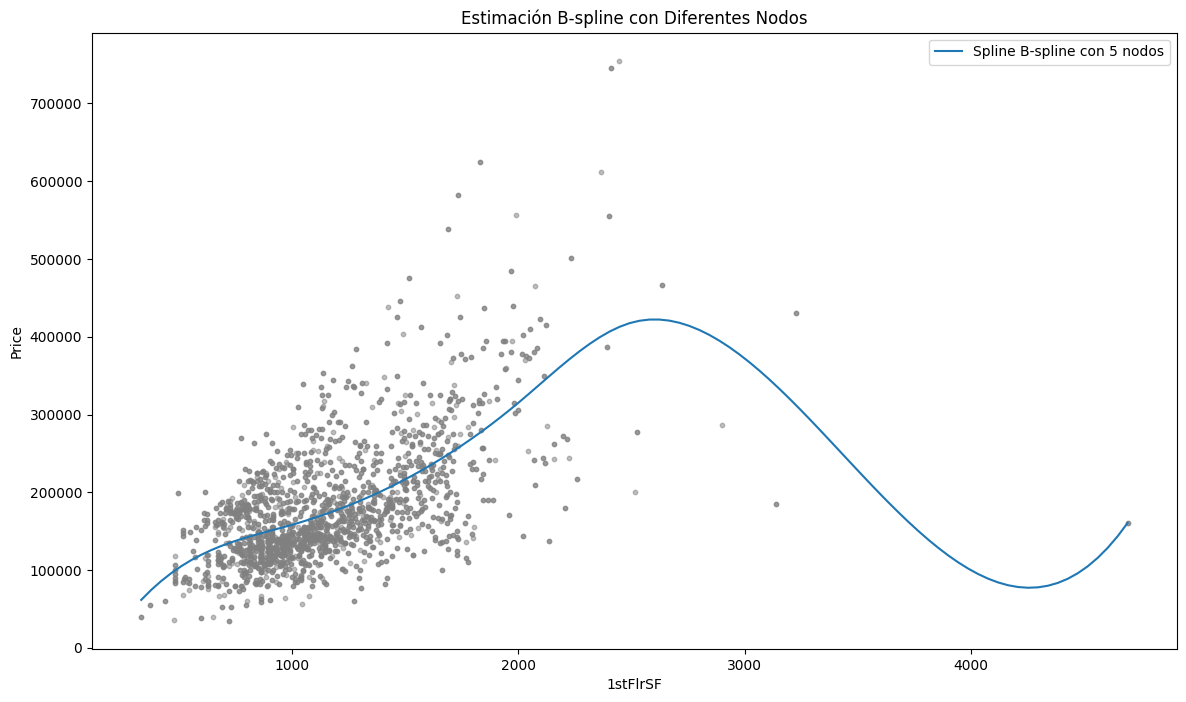

Gráfica de B-splines para la variable 'GrLivArea':


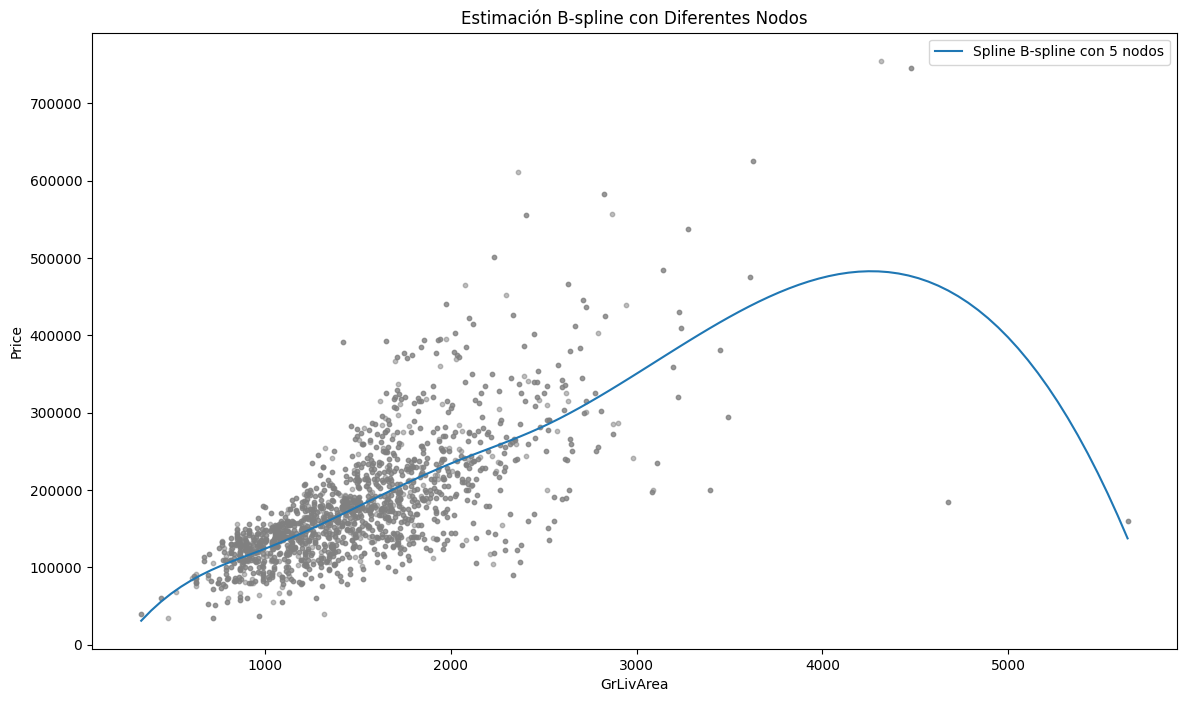

Gráfica de B-splines para la variable 'TotRmsAbvGrd':


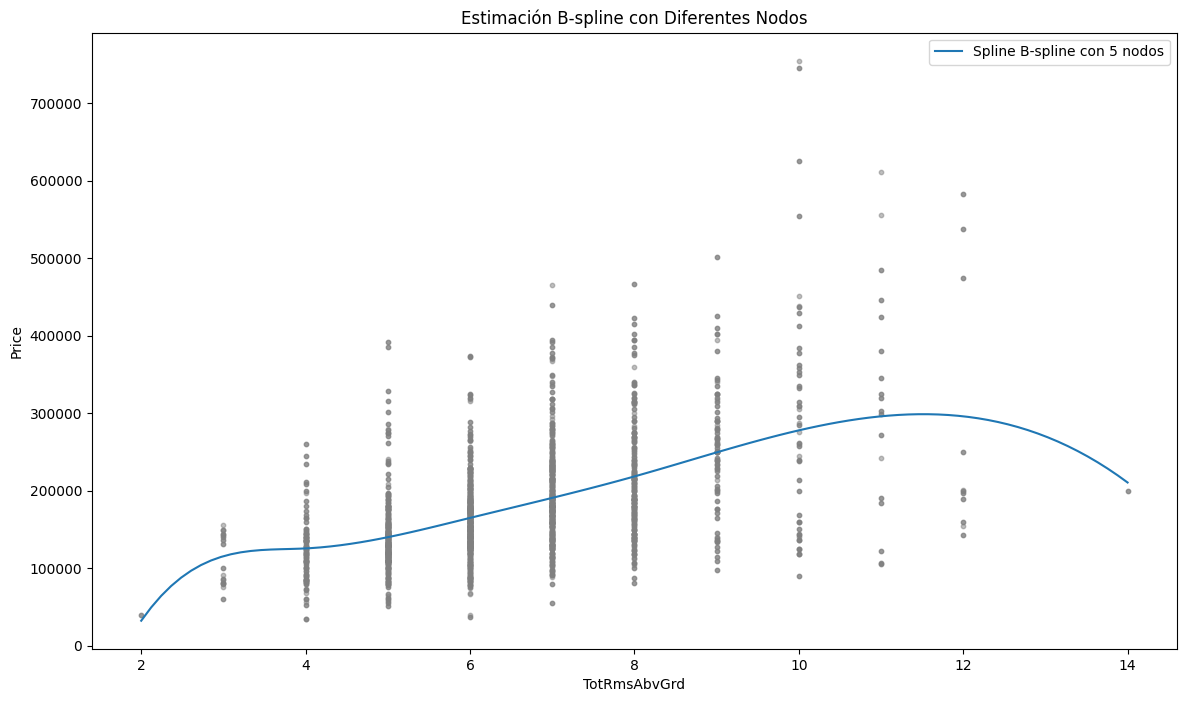

Gráfica de B-splines para la variable 'GarageArea':


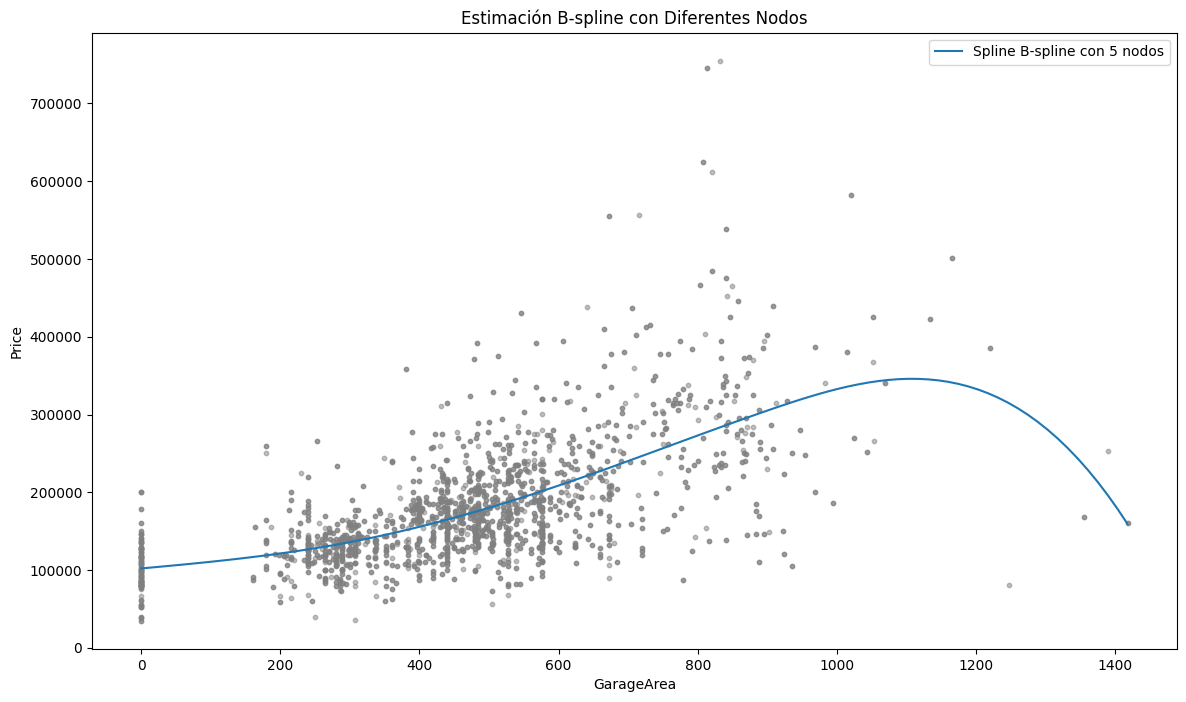

In [ ]:
for variable, knots in zip(X_numeric.columns, knots_list):
    print(f"Gráfica de B-splines para la variable '{variable}':")
    bspline_plot(X_train2[variable], X_val2[variable], y_train2, y_val2, [knots], variable)

El rendimiento del modelo con splines naturales es mejor que el de splines cúbicos naturales.

**RMSE:**
- Para natural_cubic_spline, el RMSE disminuye ligeramente a medida que aumenta el número de grados de libertad (df), lo que indica una mejora en la capacidad del modelo para ajustarse a los datos de validación.
- En natural_bspline, el RMSE es menor en comparación con natural_cubic_spline para un número similar de nodos, lo que sugiere un mejor ajuste del modelo de spline utilizando nodos estratégicamente ubicados.

**MAE**:
- Al igual que con el RMSE, el MAE tiende a disminuir ligeramente con un aumento en el número de grados de libertad en natural_cubic_spline, lo que indica una ligera mejora en la precisión del modelo.

- En natural_bspline, el MAE también es menor en comparación con natural_cubic_spline, lo que sugiere una mejor capacidad para predecir los valores reales de los precios de venta.

**R2**:
- El coeficiente de determinación R2 muestra una tendencia similar al RMSE y al MAE en natural_cubic_spline, aumentando ligeramente con un mayor número de grados de libertad.
- En natural_bspline, el R2 es mayor en comparación con natural_cubic_spline, lo que indica que el modelo de spline con nodos estratégicamente ubicados explica mejor la variabilidad de los datos de validación.

En resumen, los resultados sugieren que el modelo de spline utilizando nodos estratégicamente ubicados (natural_bspline) tiene un mejor rendimiento en términos de RMSE, MAE y R2 en comparación con el modelo de spline cúbico natural (natural_cubic_spline). Esto puede indicar que la ubicación de los nodos en natural_bspline permite una mejor captura de la complejidad de los datos y, por lo tanto, resulta en una mejor capacidad predictiva del modelo.

### 3. Modelado con Regresión con Kernel

Funciones diferentes kernels

In [ ]:
from scipy.spatial import distance

In [ ]:
def knn_basic(k: int, point: float, data_x: np.ndarray, data_y: np.ndarray) -> float:
    idx_sorted = np.argsort((data_x - point) * (data_x - point))[:k]
    return data_y[idx_sorted].mean()

def knn_multi(k: int, point: np.ndarray, data_x: np.ndarray, data_y: np.ndarray) -> float:
    distances = np.array([distance.euclidean(point, x) for x in data_x])

    idx_sorted = np.argsort(distances)[:k]

    return data_y[idx_sorted].mean()

Implementamos el método del vecino más cercano

In [ ]:
def kernel_basic(X_train, X_val, y_train, y_val, k_values):
    results = []

    for k in k_values:
        all_rmse = []
        all_mae = []
        all_r2 = []

        for column in X_train.columns:
            X_train_col = X_train[column].values
            X_val_col = X_val[column].values

            mse_basic = np.sqrt(mean_squared_error(y_val, [knn_basic(k, x, X_train_col, y_train.values) for x in X_val_col]))
            mae_basic = mean_absolute_error(y_val, [knn_basic(k, x, X_train_col, y_train.values) for x in X_val_col])
            r2_basic = r2_score(y_val, [knn_basic(k, x, X_train_col, y_train.values) for x in X_val_col])

            all_rmse.append(mse_basic)
            all_mae.append(mae_basic)
            all_r2.append(r2_basic)

        avg_mse = np.mean(all_rmse)
        avg_mae = np.mean(all_mae)
        avg_r2 = np.mean(all_r2)

        results.append({
            "k": k,
            "RMSE": avg_mse,
            "MAE": avg_mae,
            "R2": avg_r2
        })

    return pd.DataFrame(results)

def plot_kernel_basic(X_train, y_train, k_values):
    for i, feature in enumerate(X_train.columns):
        plt.figure(figsize=(14, 8))
        plt.scatter(X_train[feature], y_train, label='Datos de entrenamiento', alpha=0.5, color='skyblue')
        plt.title(f'{feature} vs. Sale Price')
        plt.xlabel(feature)
        plt.ylabel('Sale Price')

        xgrid = np.linspace(X_train[feature].min(), X_train[feature].max(), 100)

        for k in k_values:
            y_knn = np.array([knn_basic(k, x, X_train[feature].values, y_train.values) for x in xgrid])
            plt.plot(xgrid, y_knn, label=f'k-NN (k={k})')

        plt.legend()
        plt.tight_layout()
        plt.show()

Resultados del modelo usando variables númericas y categóricas

In [ ]:
categorical_features = ['Neighborhood', 'ExterQual']
numeric_features = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

X = data_cleaned[numeric_features + categorical_features]
y = data_cleaned['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

k_values = [10, 50, 100, 200]
results_knn_basic = kernel_basic(X_train, X_val, y_train, y_val, k_values)
results_knn_basic

k          RMSE           MAE        R2
0   10  62475.323257  41970.084075  0.485941
1   50  62774.512224  41861.708382  0.481522
2  100  65855.681485  43463.063159  0.428538
3  200  68073.327612  44725.700520  0.389190

Resultados solo con numéricas

In [ ]:
numeric_features = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea']

X = data_cleaned[numeric_features]
y = data_cleaned['SalePrice']

X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(X, y, test_size=0.2, random_state=42)

results_knn_basic_num = kernel_basic(X_train_num, X_val_num, y_train_num, y_val_num, k_values)
results_knn_basic_num

k          RMSE           MAE        R2
0   10  63200.407200  42587.052511  0.472860
1   50  61893.785954  41578.440434  0.494685
2  100  63760.245552  42073.349115  0.465271
3  200  65810.304480  42848.435702  0.431201

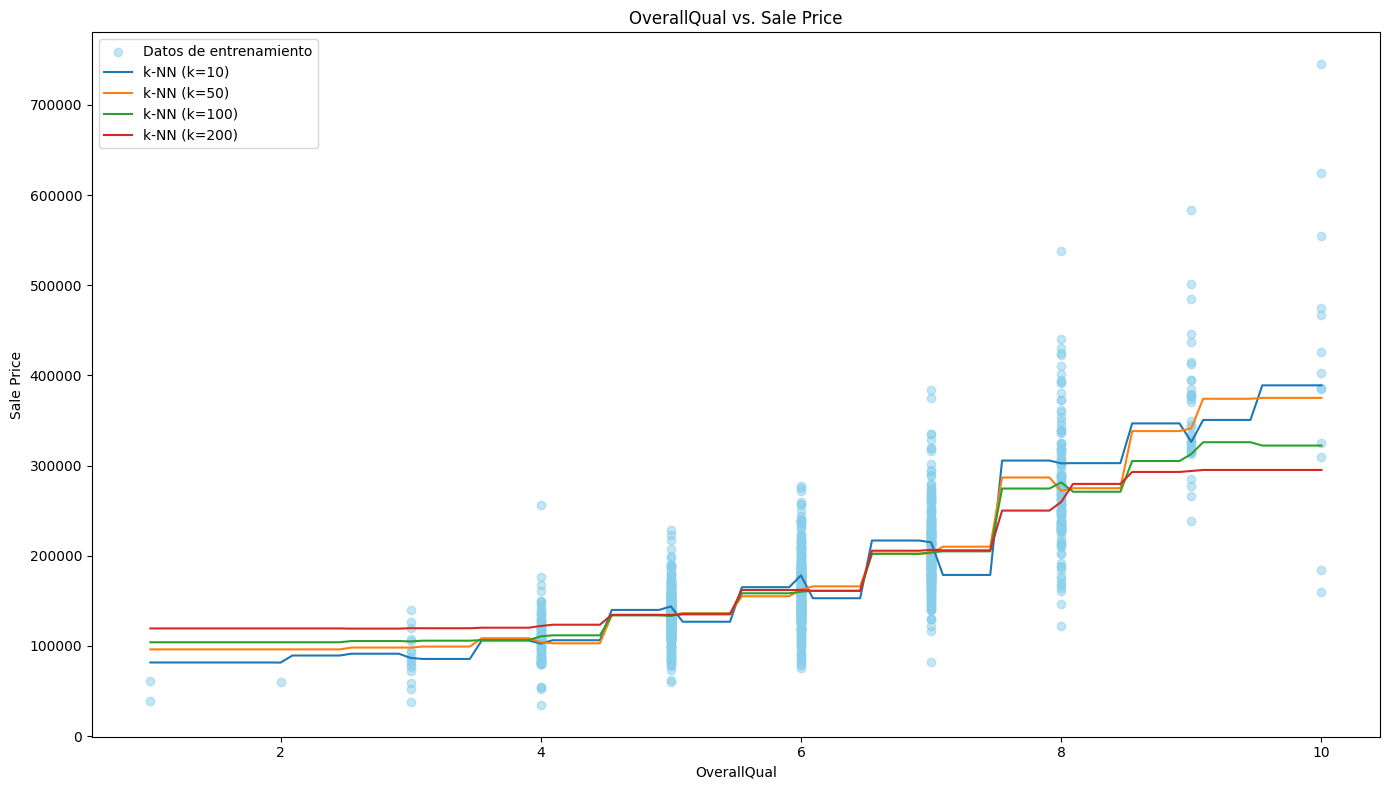

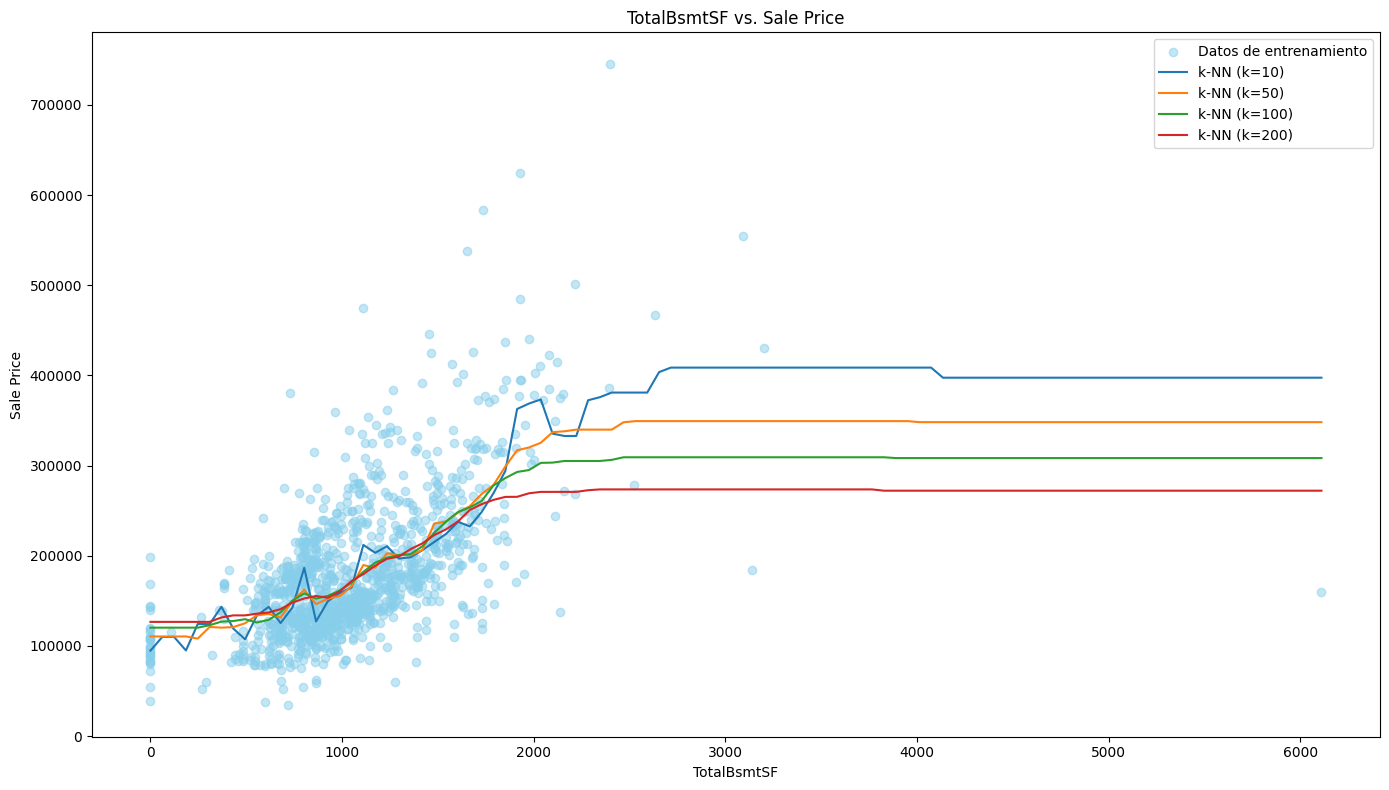

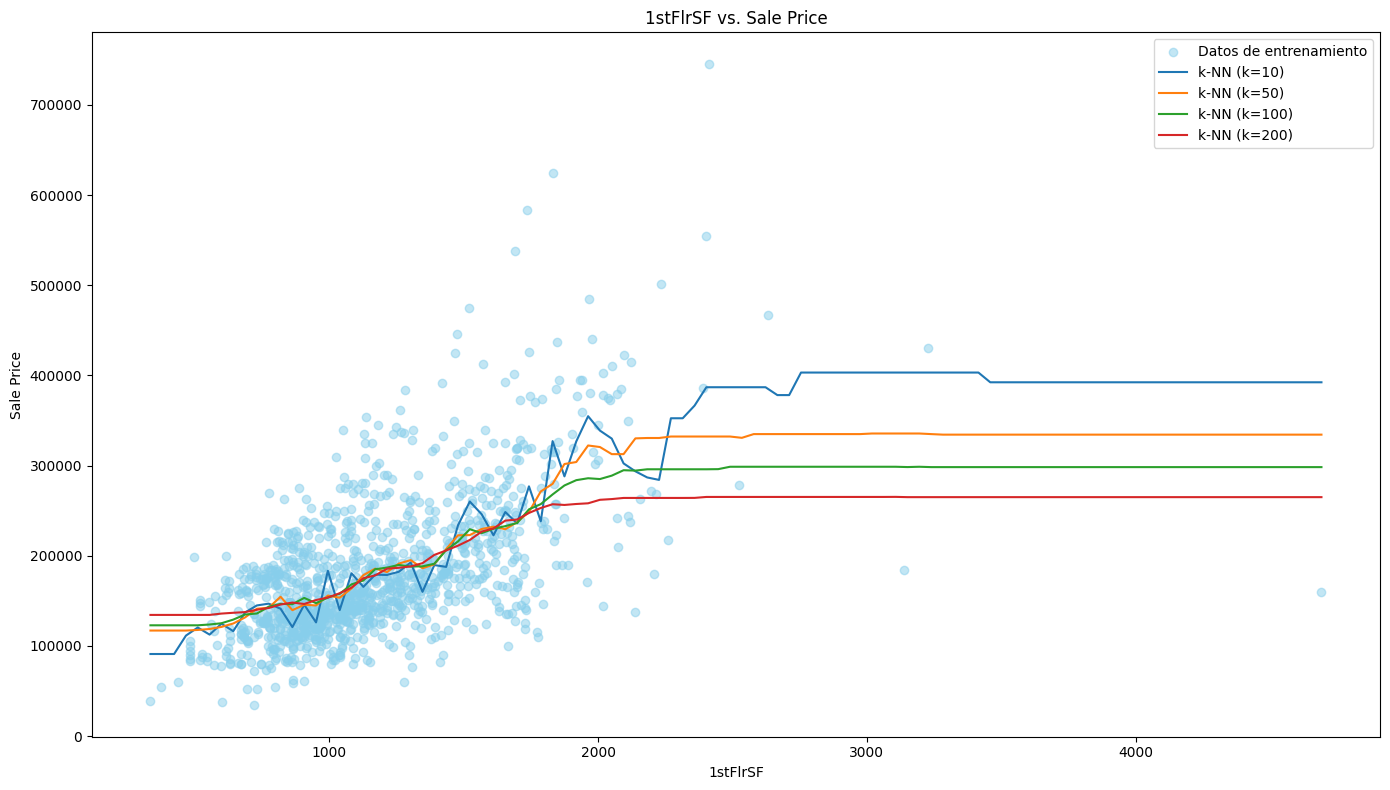

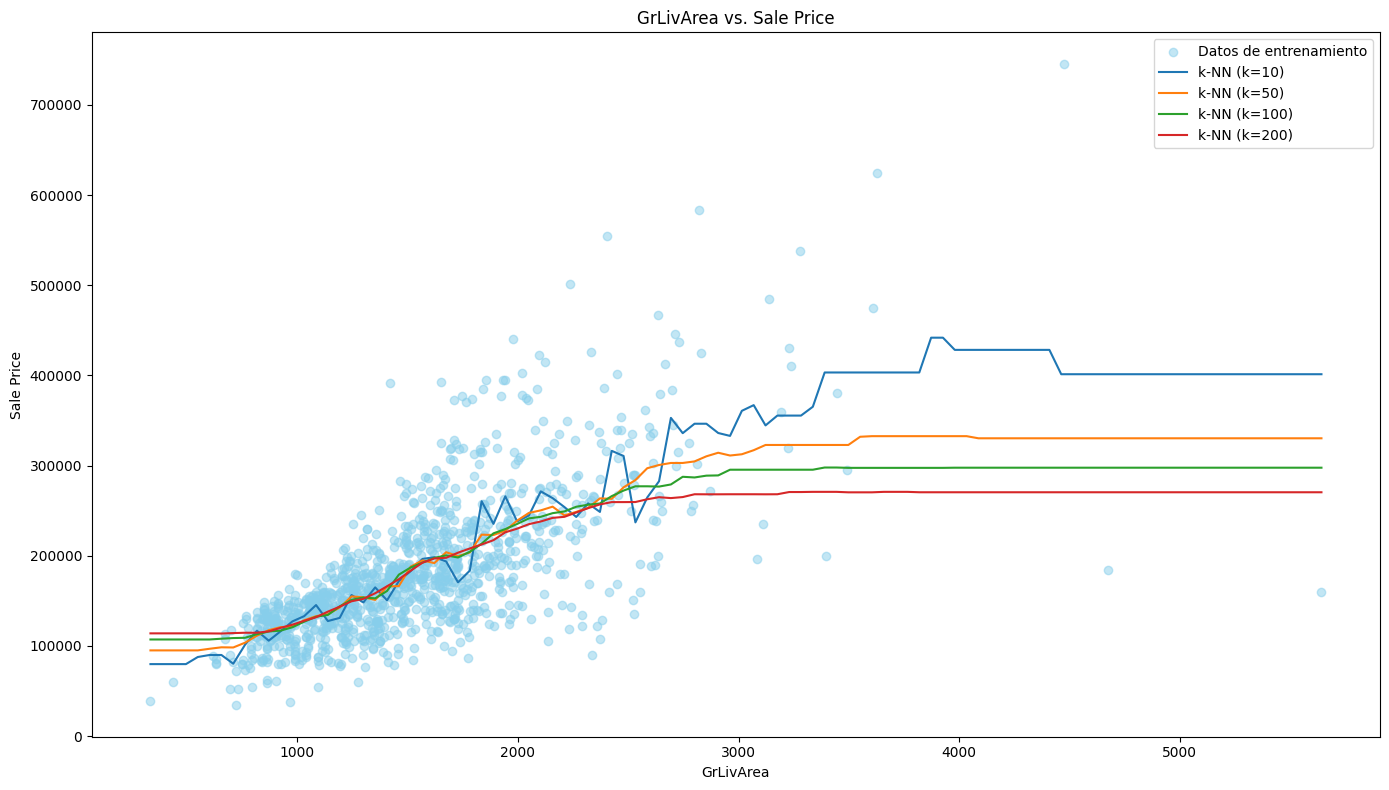

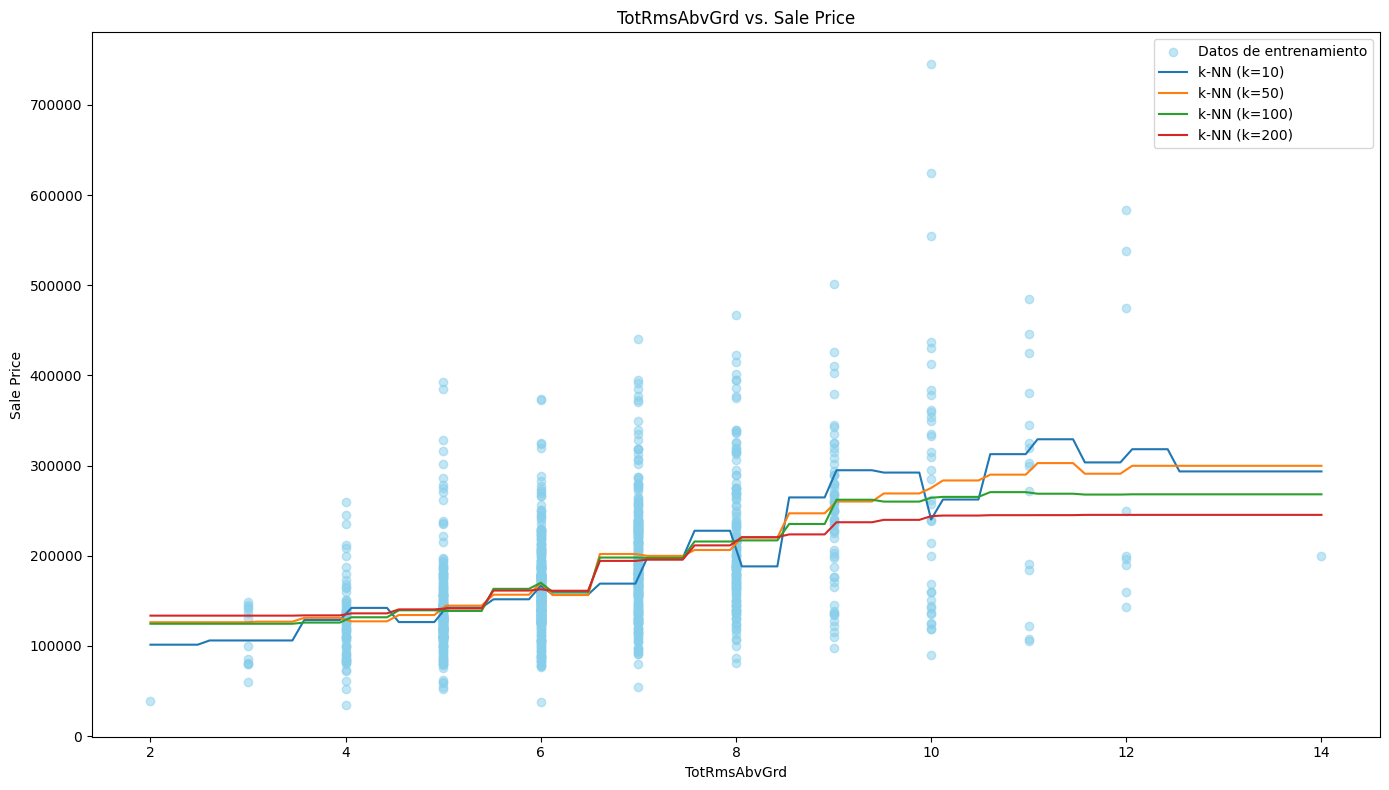

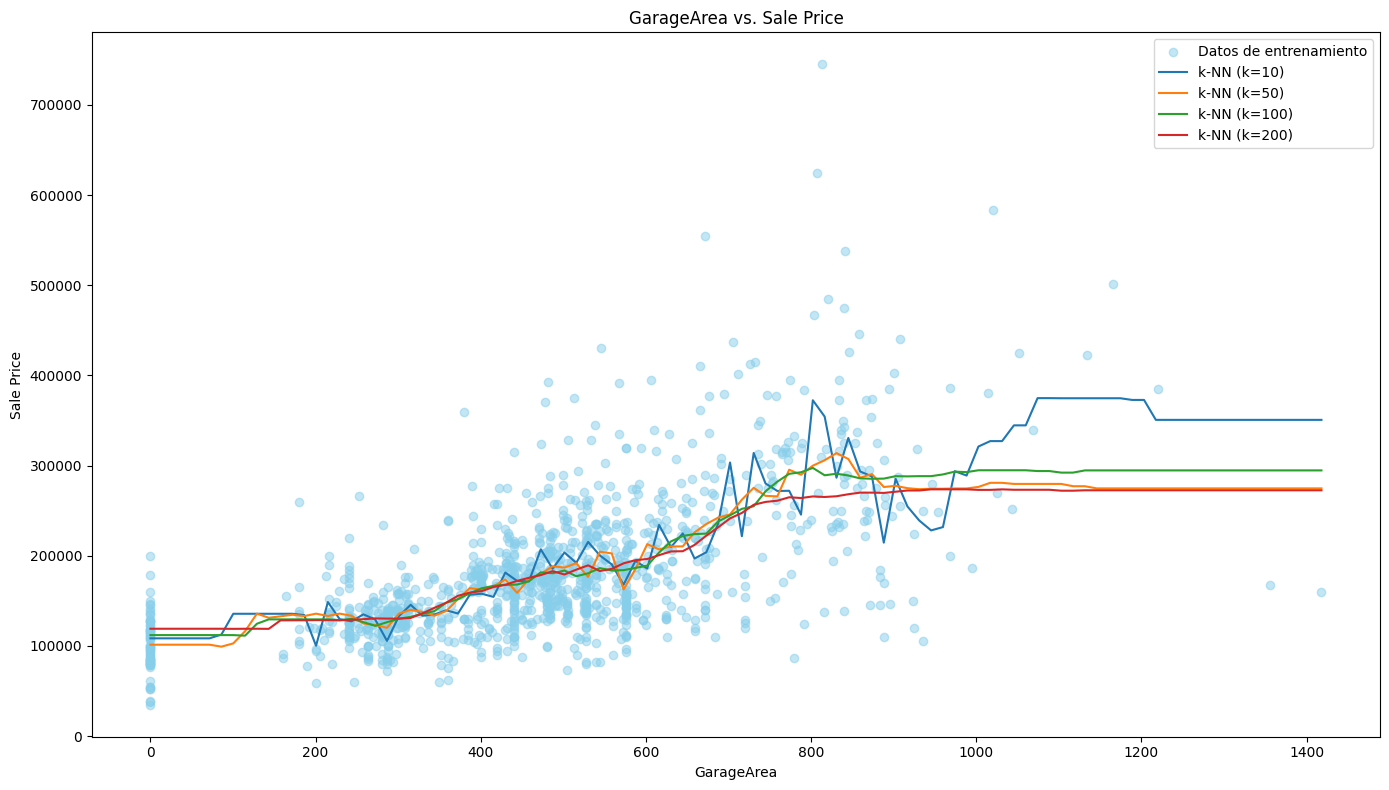

In [ ]:
plot_kernel_basic(X_train_num, y_train_num, k_values)

Podemos ver que knn_basic tiene mucho ruido, entonces vamos a realizar ahora un modelo usando un enfoque de kernel multivariable

In [ ]:
def kernel_multi(X_train, X_val, y_train, y_val, k_values):
    results = []

    for k in k_values:
        mse_multi = np.sqrt(mean_squared_error(y_val, [knn_multi(k, x, X_train.values, y_train.values) for x in X_val.values]))
        mae_multi = mean_absolute_error(y_val, [knn_multi(k, x, X_train.values, y_train.values) for x in X_val.values])
        r2_multi = r2_score(y_val, [knn_multi(k, x, X_train.values, y_train.values) for x in X_val.values])

        results.append({
            "k": k,
            "RMSE": mse_multi,
            "MAE": mae_multi,
            "R2": r2_multi
        })

    return pd.DataFrame(results)

In [ ]:
results_multi_num = kernel_multi(X_train_num, X_val_num, y_train_num, y_val_num, k_values)
results_multi_num

k          RMSE           MAE        R2
0   10  43666.078036  26829.059247  0.751415
1   50  47866.336880  28158.354110  0.701292
2  100  51741.410630  30368.817534  0.650970
3  200  56724.721077  33142.270291  0.580501

Podemos ver que los resultados de knn_multi son considerablemente mejores que los de knn_basic, especialmente en términos de RMSE, MAE y R2. Esto muestra la ventaja de utilizar un enfoque multivariable, ya que puede capturar mejor las relaciones entre múltiples características y la variable objetivo.

Vamos a hacer uso de KernelRidge ya que:

- Puede que haya mayor flexibilidad, KernelRidge permite utilizar diferentes funciones de kernel, como lineal, polinomial, radial (RBF), sigmoidal, entre otras. Esto proporciona flexibilidad para adaptar el modelo a la estructura y distribución de los datos.

- Capacidad para manejar datos no lineales

- KernelRidge utiliza regularización para controlar el sobreajuste del modelo. Esto es útil cuando hay multicolinealidad entre las características.


In [ ]:
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def kernel_ridge(X_train, X_val, y_train, y_val, kernels, alpha):
    results = []

    for kernel in kernels:
        krr = KernelRidge(alpha=alpha, kernel=kernel)
        krr.fit(X_train, y_train)

        y_pred = krr.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        results.append({
            "Kernel": kernel,
            "Alpha": alpha,
            "RMSE": rmse,
            "MAE": mae,
            "R^2": r2
        })

    return pd.DataFrame(results)

def plot_kernel_ridge(X_train, y_train, kernels, alpha):
    for feature in X_train.columns:
        for kernel in kernels:
            krr = KernelRidge(alpha=alpha, kernel=kernel)
            krr.fit(X_train[[feature]], y_train)

            plt.figure(figsize=(14, 8))
            plt.scatter(X_train[feature], y_train, label='Datos de entrenamiento', alpha=0.5, color='skyblue')
            plt.title(f'Kernel Ridge con kernel={kernel}, alpha={alpha}, y característica={feature}')
            plt.xlabel(feature)
            plt.ylabel('y')

            x_values = np.linspace(min(X_train[feature]), max(X_train[feature]), 100).reshape(-1, 1)
            y_pred = krr.predict(x_values)
            plt.plot(x_values, y_pred, label='Predicción', color='orange')

            plt.legend()
            plt.tight_layout()
            plt.show()

Resultados con todas las variables

In [ ]:
kernels = ['poly']
alpha = 1

result_kernels = kernel_ridge(X_train, X_val, y_train, y_val, kernels, alpha)
result_kernels

Kernel  Alpha          RMSE           MAE       R^2
0   poly      1  56461.302857  26621.157534  0.584388

Resultados con solo variables numéricas

In [ ]:
result_kernels_num = kernel_ridge(X_train_num, X_val_num, y_train_num, y_val_num, kernels, alpha)
result_kernels_num

Kernel  Alpha          RMSE           MAE       R^2
0   poly      1  44450.123781  24962.246147  0.742408

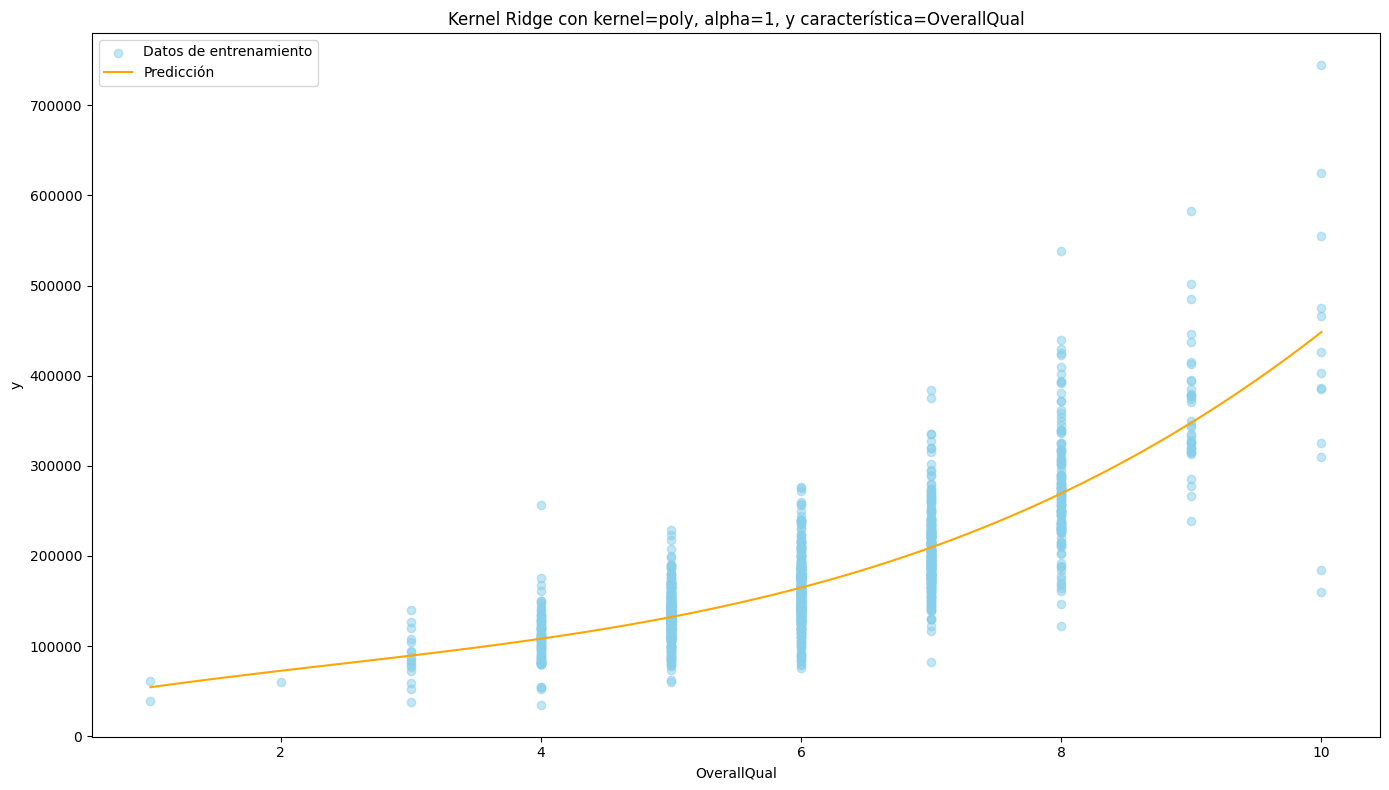

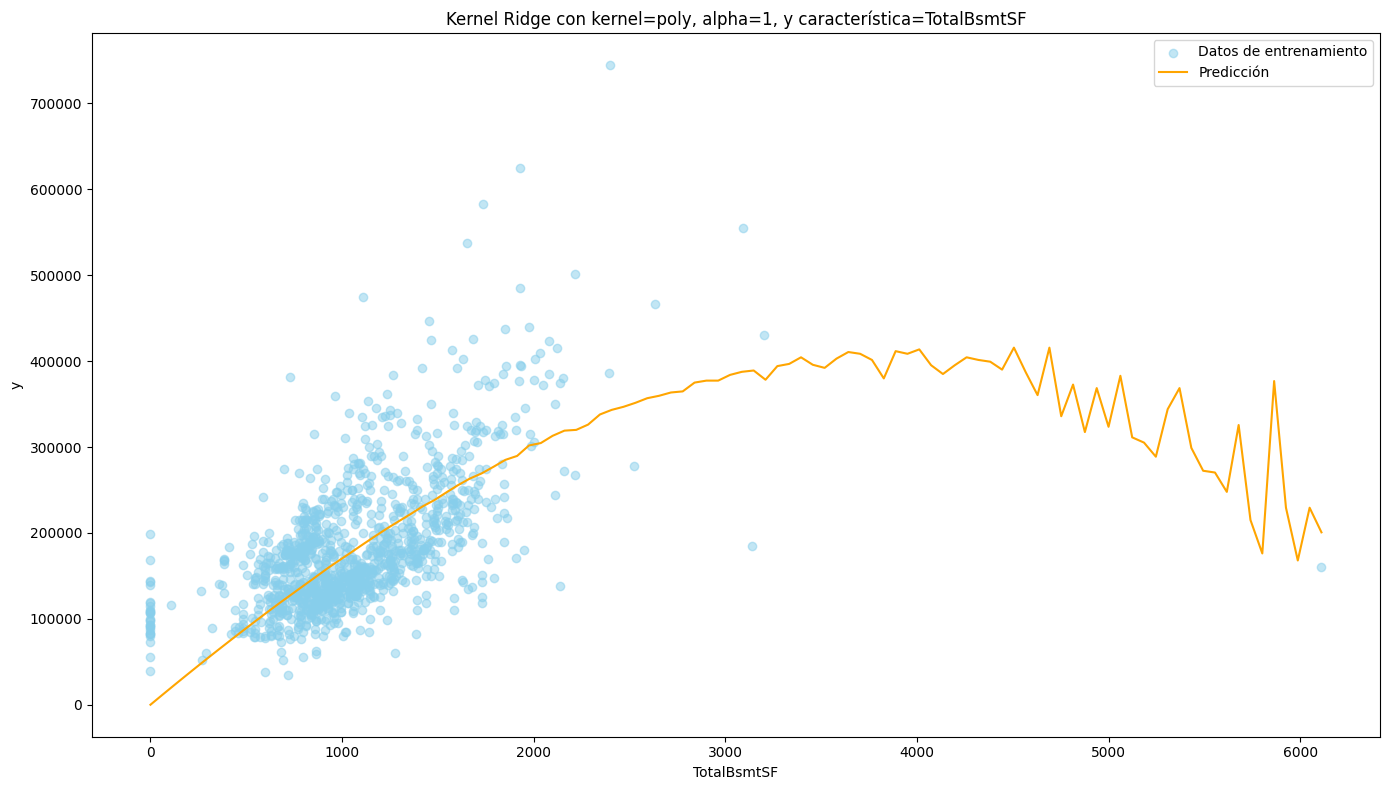

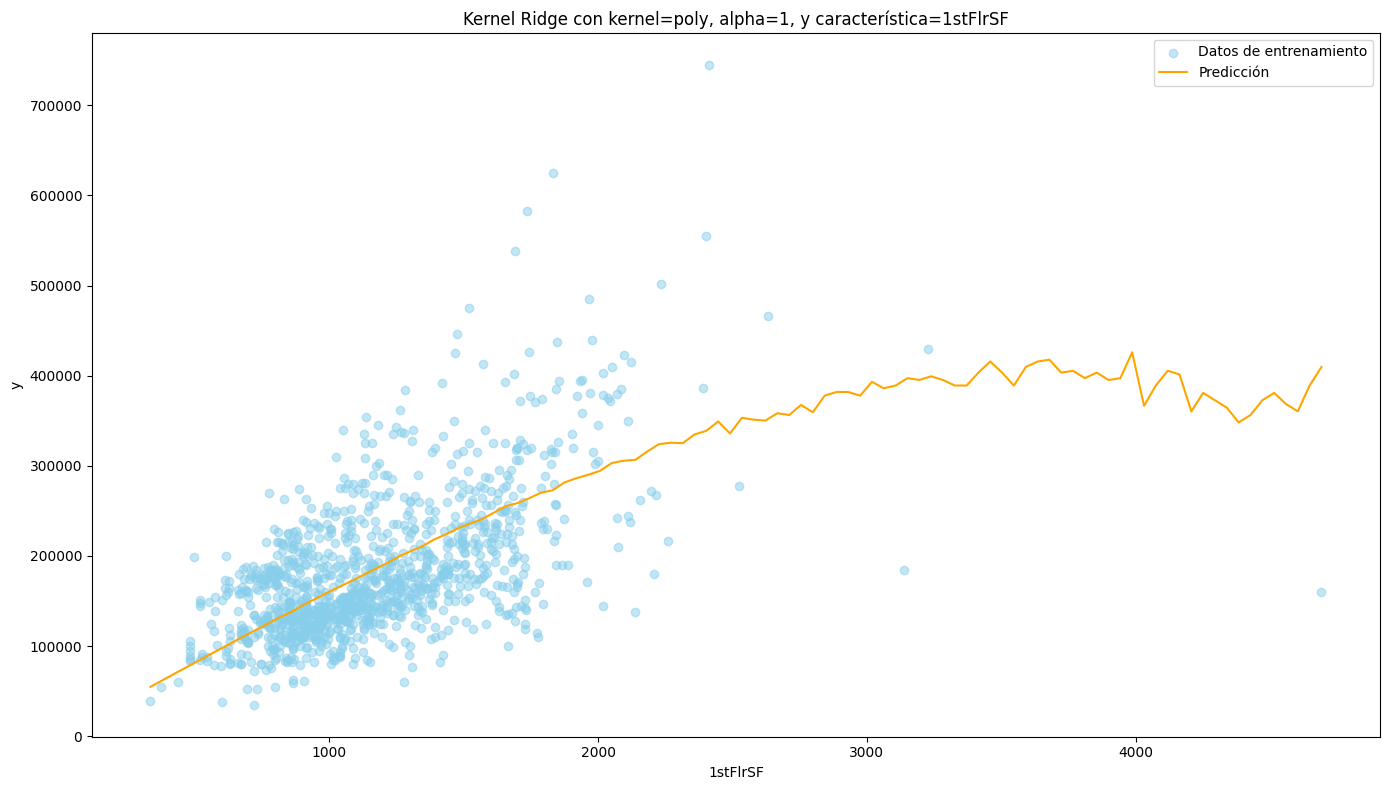

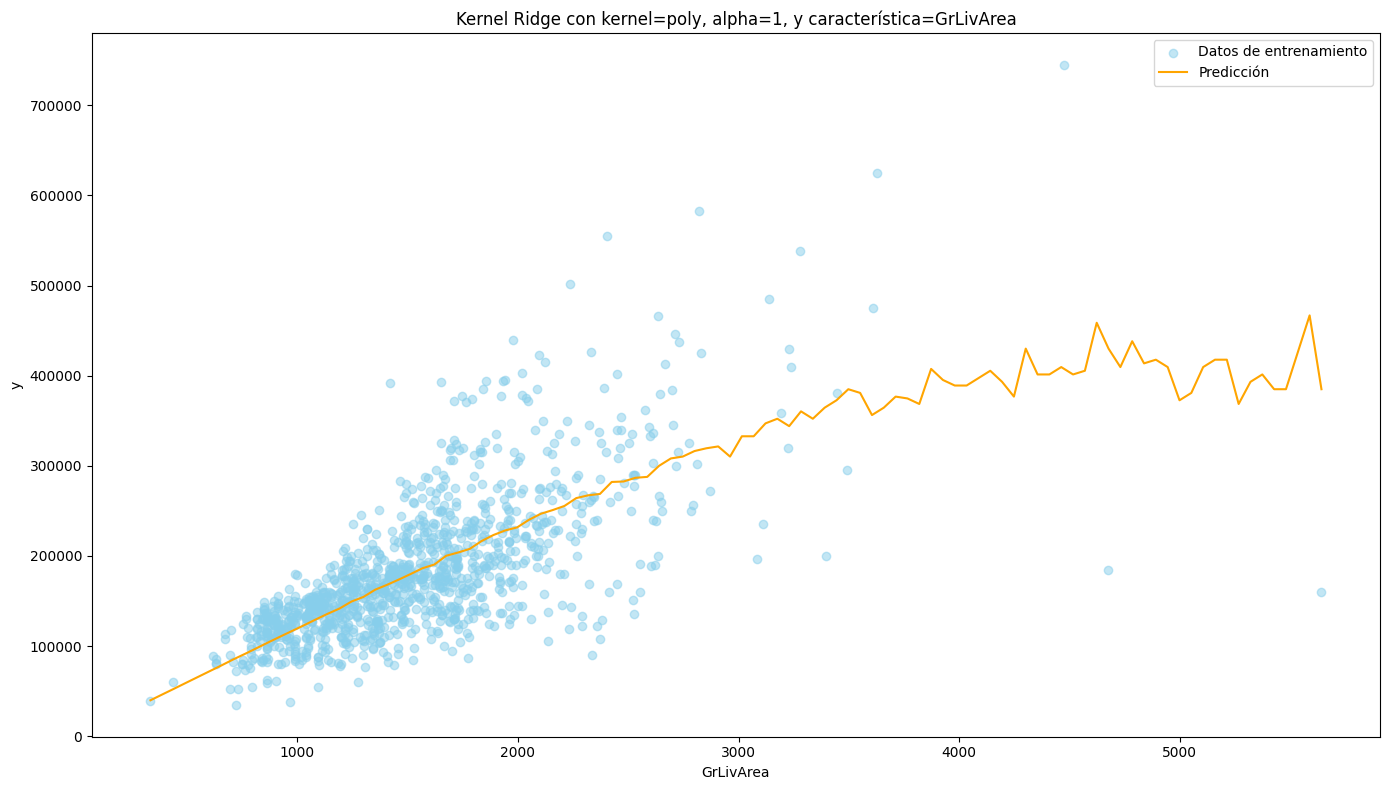

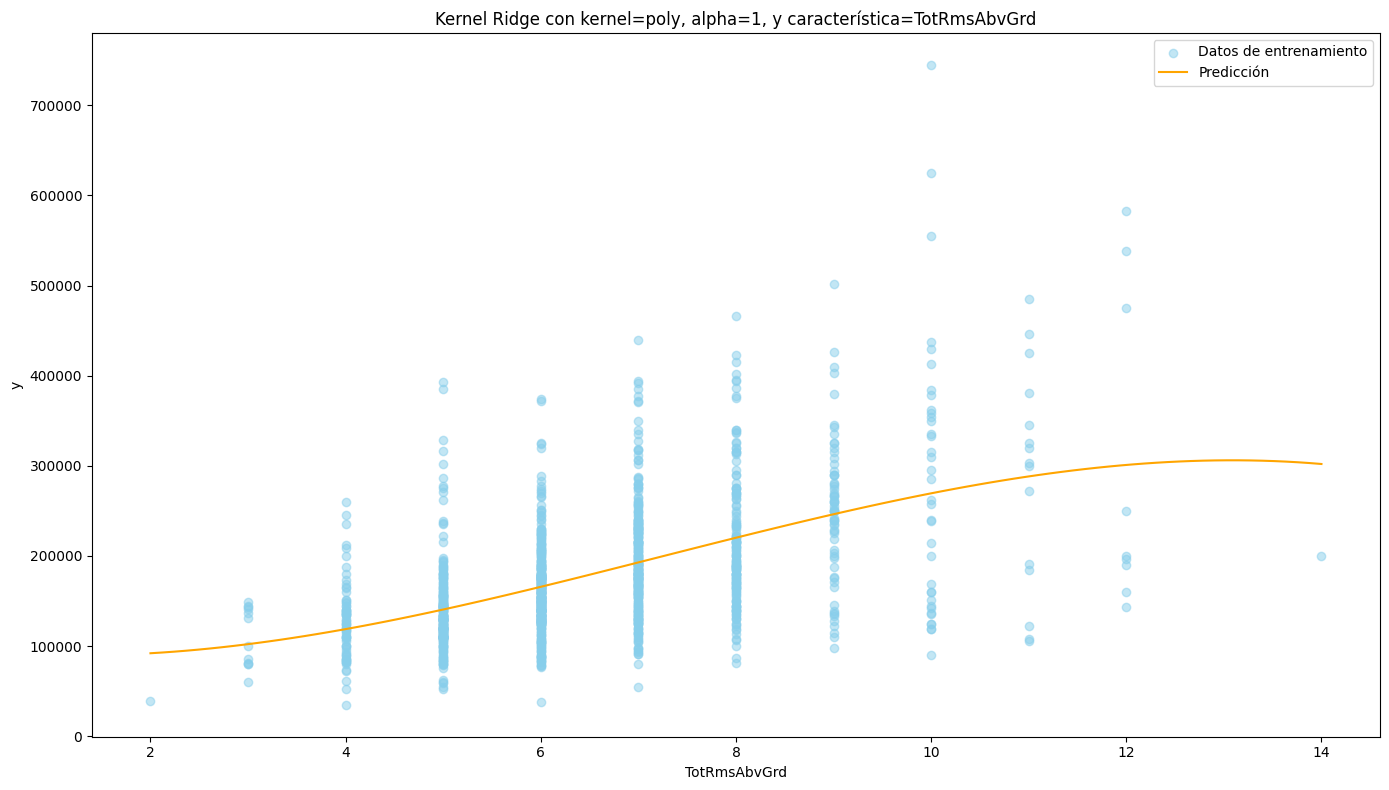

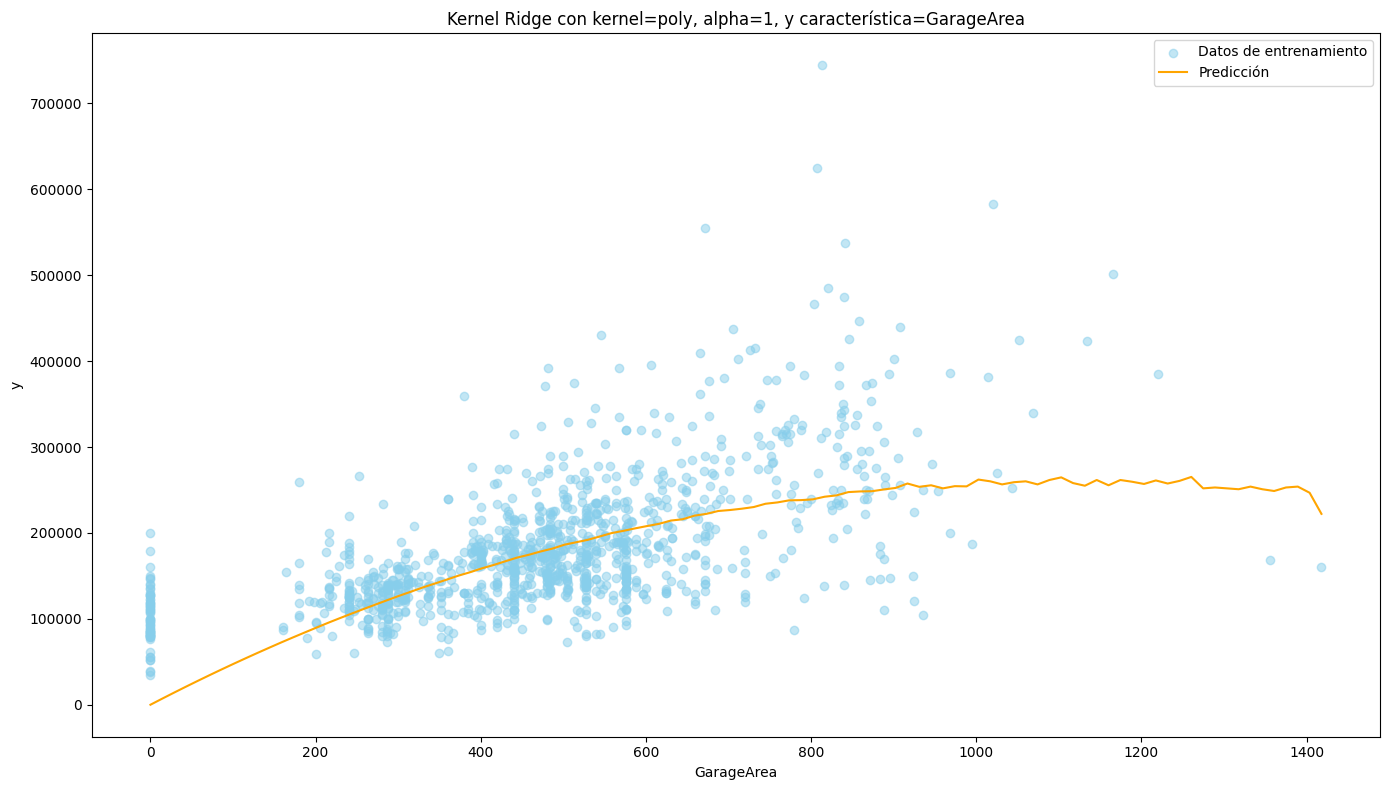

In [ ]:
plot_kernel_ridge(X_train_num, y_train_num, kernels, alpha)

En cuanto a los resultados con kernel:

**RMSE y MAE:**

*knn basic*
- Con todas las variables el RMSE y el MAE aumenta ligeramente a medida que aumenta el valor de k (el número de vecinos). En cambio con una cantidad de vecinos mas pequeña hay una mejora en la capacidad del modelo para ajustarse a los datos.

- Con solo variables numéricas: El RMSE y el MAE en este caso con un k grande es un poco mejor que con todas las variables.

*KernelRidge 'poly'*
- Tanto con todas las variables y solo las numéricas el RMSE y el MAE es sustancialmente más bajo que el de knn_basic, lo que indica un mejor ajuste del modelo.

**R2:**

*knn_basic*
- El coeficiente de determinación R2 tiende a disminuir con todas las variables si k es grande, con solo las numéricas también disminuye pero tiene mejores resultados que con todas las variables.

*KernelRidge 'poly'*
- El R2 es sustancialmente más alto en comparación con knn_basic para ambos conjuntos de variables, lo que sugiere que el modelo de KernelRidge explica mejor la variabilidad de los datos de validación.

En resumen, los resultados indican que el modelo KernelRidge con kernel 'poly' supera al modelo knn_basic en términos de RMSE, MAE y R2, lo que sugiere un mejor ajuste del modelo y una mayor capacidad predictiva, especialmente cuando se consideran solo las variables numéricas. Esto puede atribuirse a la capacidad del modelo KernelRidge para capturar relaciones no lineales entre las características y la variable objetivo, así como para manejar de manera más efectiva la complejidad de los datos.

Aunque no hay que descartar kernel multivariable, pues con una cantidad pequeña de vecinos (k=10) obtienen un resultado mejor al de KernelRidge

### 4. Resultados

Recordemos que nustras variables elegidas para el análisis fueron:
- OverallQual
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- TotRmsAbvGrd
- GarageArea
- Neighborhood   
- ExterQual

Veamos los resultados de los diferentes modelos Splines y Kernel

In [ ]:
print('\nResultados con variables numéricas y categóricas:')
print('\nMétodo KNN:\n', results_knn_basic)
print('\nKernelRidge poly\n', result_kernels)

print('\n\nResultados con solo variables numéricas:')
print('\nSplines cúbicos naturales:\n', results_cc_num)
print('\nSplines naturales (bs):\n', results_bspline_num)
print('\nMétodo KNN:\n', results_knn_basic_num)
print('\nKernel multivariable:\n', results_multi_num)
print('\nKernelRidge poly\n', result_kernels_num)


Resultados con variables numéricas y categóricas:

Método KNN:
      k          RMSE           MAE        R2
0   10  62475.323257  41970.084075  0.485941
1   50  62774.512224  41861.708382  0.481522
2  100  65855.681485  43463.063159  0.428538
3  200  68073.327612  44725.700520  0.389190

KernelRidge poly
   Kernel  Alpha          RMSE           MAE       R^2
0   poly      1  56461.302857  26621.157534  0.584388


Resultados con solo variables numéricas:

Splines cúbicos naturales:
    Grados de libertad          RMSE           MAE        R2
0                   3  63759.002756  45168.231164  0.462940
1                   5  63321.150917  43176.712280  0.470476
2                   7  63347.407937  42906.103739  0.470564

Splines naturales (bs):
    Nodes          RMSE           MAE        R2
0      5  62533.849824  41716.924598  0.482267

Método KNN:
      k          RMSE           MAE        R2
0   10  63200.407200  42587.052511  0.472860
1   50  61893.785954  41578.440434  0.494685
2 

Finalmente, podemos ver que únicamente hicimos uso de kernel al evaluar con las variables tanto numéricas como categóricas, esto por lo que no era necesario hacer splines con las variables categóricas. Nuestro mejor modelo fue con KernelRidge 'poly'.

Por otro lado, solo con las variables numéricas hicimos tanto kernel como splines:
- En donde el mejor modelo con splines fue el de los splines naturales (bs), definiendo los knots según cada variable.
- Y con kernel, fue el kernel multivariable haciendo uso de un parámetro de k igual a 10.



In [ ]:
# Por ejemplo:
X_train_subset = X_train[['OverallQual', 'GrLivArea', 'TotalBsmtSF']]
house_features = pd.DataFrame({'OverallQual': [8], 'GrLivArea': [5000], 'TotalBsmtSF': [4000]})

# Llama a la función knn_multi para hacer la predicción
predicted_price = knn_multi(10, house_features.values.flatten(), X_train_subset.values, y_train.values)

# Imprime el resultado de la predicción
print("Precio predicho de la casa:", predicted_price)

Precio predicho de la casa: 433925.0
